###MODEL PART

In [1]:
# Cell 1: Install and Import Required Libraries
!pip install tensorflow opencv-python matplotlib scikit-image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import os
from google.colab import files
from PIL import Image
import io

print("TensorFlow Version:", tf.__version__)



TensorFlow Version: 2.18.0


In [2]:
# Cell 2: Download and Load EMNIST Dataset
# Download EMNIST dataset
!wget -q https://biometrics.nist.gov/cs_links/EMNIST/matlab.zip
!unzip -q matlab.zip

# Load EMNIST data
import scipy.io

def load_emnist_data():
    """Load EMNIST ByClass dataset"""
    mat_data = scipy.io.loadmat('matlab/emnist-byclass.mat')

    # Extract training and test data
    X_train = mat_data['dataset'][0][0][0][0][0][0]
    y_train = mat_data['dataset'][0][0][0][0][0][1]
    X_test = mat_data['dataset'][0][0][1][0][0][0]
    y_test = mat_data['dataset'][0][0][1][0][0][1]

    # Reshape images (28x28)
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)

    # Rotate and flip images (EMNIST format correction)
    X_train = np.rot90(X_train, k=-1, axes=(1, 2))
    X_train = np.fliplr(X_train)
    X_test = np.rot90(X_test, k=-1, axes=(1, 2))
    X_test = np.fliplr(X_test)

    return X_train, y_train.flatten(), X_test, y_test.flatten()

# Load data
X_train, y_train, X_test, y_test = load_emnist_data()

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Show class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class distribution (first 10): {dict(zip(unique[:10], counts[:10]))}")
print(f"Most frequent class has {max(counts)} samples")
print(f"Least frequent class has {min(counts)} samples")

Training data shape: (697932, 28, 28, 1)
Training labels shape: (697932,)
Test data shape: (116323, 28, 28, 1)
Test labels shape: (116323,)
Number of classes: 62
Class distribution (first 10): {np.uint8(0): np.int64(34585), np.uint8(1): np.int64(38374), np.uint8(2): np.int64(34203), np.uint8(3): np.int64(35143), np.uint8(4): np.int64(33535), np.uint8(5): np.int64(31416), np.uint8(6): np.int64(34232), np.uint8(7): np.int64(35754), np.uint8(8): np.int64(33946), np.uint8(9): np.int64(33847)}
Most frequent class has 38374 samples
Least frequent class has 1896 samples


Character mapping: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] ... ['q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


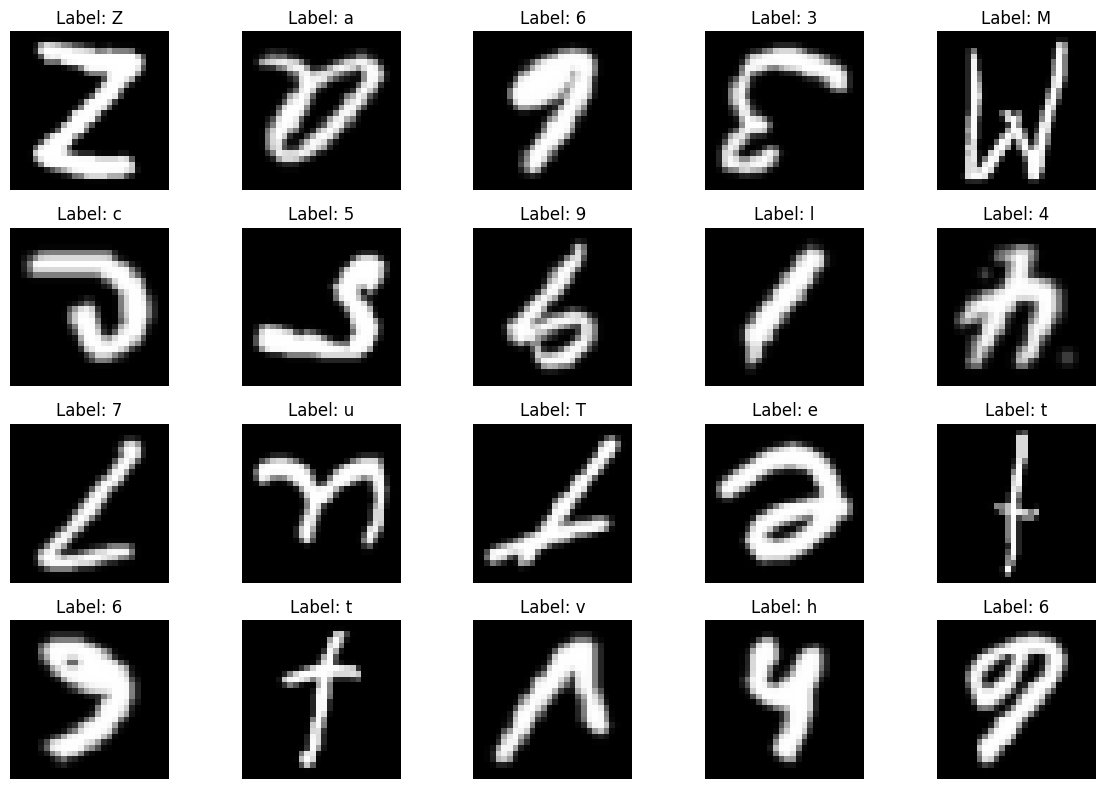

In [3]:
# Cell 3: Data Preprocessing and Visualization
# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Get class mapping (EMNIST balanced includes digits + letters)
num_classes = len(np.unique(y_train))

# Create character mapping
def get_char_mapping():
    """Create mapping from class labels to characters"""
    chars = []
    # Digits 0-9
    for i in range(10):
        chars.append(str(i))
    # Uppercase letters A-Z
    for i in range(26):
        chars.append(chr(ord('A') + i))
    # Lowercase letters a-z
    for i in range(26):
        chars.append(chr(ord('a') + i))
    return chars

char_mapping = get_char_mapping()
print("Character mapping:", char_mapping[:10], "...", char_mapping[-10:])

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Visualize some samples
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {char_mapping[y_train[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Cell 4: Build CNN Model Architecture
def create_cnn_model(input_shape, num_classes):
    """Create a CNN model for character recognition"""
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile model
model = create_cnn_model((28, 28, 1), num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,734 (2.11 MB)

 Trainable params: 550,750 (2.10 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [5]:
# Cell 5: Train the Model with Class Weights
# Calculate class weights to handle imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Sample class weights:")
for i in range(min(10, len(class_weight_dict))):
    char = char_mapping[i]
    weight = class_weight_dict[i]
    print(f"Class {i} ('{char}'): weight = {weight:.3f}")

# Create callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model with class weights
history = model.fit(
    X_train, y_train_cat,
    batch_size=128,
    epochs=50,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weight_dict,  # Added class weights
    callbacks=[checkpoint, reduce_lr, early_stopping],
    verbose=1
)


Sample class weights:
Class 0 ('0'): weight = 0.325
Class 1 ('1'): weight = 0.293
Class 2 ('2'): weight = 0.329
Class 3 ('3'): weight = 0.320
Class 4 ('4'): weight = 0.336
Class 5 ('5'): weight = 0.358
Class 6 ('6'): weight = 0.329
Class 7 ('7'): weight = 0.315
Class 8 ('8'): weight = 0.332
Class 9 ('9'): weight = 0.333
Epoch 1/50
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5526 - loss: 1.5729
Epoch 1: val_accuracy improved from -inf to 0.78763, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 64s 9ms/step - accuracy: 0.5526 - loss: 1.5728 - val_accuracy: 0.7876 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 2/50
5450/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7421 - loss: 0.7050
Epoch 2: val_accuracy improved from 0.78763 to 0.80174, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.7421 - loss: 0.7050 - val_accuracy: 0.8017 - val_loss: 0.5063 - learning_rate: 0.0010
Epoch 3/50
5447/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7655 - loss: 0.6374
Epoch 3: val_accuracy improved from 0.80174 to 0.81724, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7655 - loss: 0.6374 - val_accuracy: 0.8172 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 4/50
5450/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7720 - loss: 0.6051
Epoch 4: val_accuracy did not improve from 0.81724
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.7720 - loss: 0.6051 - val_accuracy: 0.7843 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 5/50
5449/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7789 - loss: 0.5860
Epoch 5: val_accuracy did not improve from 0.81724
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - accuracy: 0.7789 - loss: 0.5860 - val_accuracy: 0.7991 - val_loss: 0.4650 - learning_rate: 0.0010
Epoch 6/50
5448/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7825 - loss: 0.5756
Epoch 6: val_accuracy did not improve from 0.81724
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.7825 - loss: 0.5756 - val_accuracy: 0.7878 - val_loss: 0.4738 - learning_rate: 0.0010
Epoch 7

5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7847 - loss: 0.5667 - val_accuracy: 0.8269 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 8/50
5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7874 - loss: 0.5553
Epoch 8: val_accuracy did not improve from 0.82693
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.7874 - loss: 0.5553 - val_accuracy: 0.8130 - val_loss: 0.4515 - learning_rate: 0.0010
Epoch 9/50
5451/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7906 - loss: 0.5474
Epoch 9: val_accuracy did not improve from 0.82693
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7906 - loss: 0.5474 - val_accuracy: 0.8256 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 10/50
5451/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7924 - loss: 0.5423
Epoch 10: val_accuracy did not improve from 0.82693
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.7924 - loss: 0.5423 - val_accuracy: 0.7907 - val_loss: 0.4643 - learning_rate: 0.0010
Epoch

5453/5453 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.7977 - loss: 0.5234 - val_accuracy: 0.8325 - val_loss: 0.4316 - learning_rate: 0.0010
Epoch 15/50
5448/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7991 - loss: 0.5209
Epoch 15: val_accuracy did not improve from 0.83248
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.7991 - loss: 0.5209 - val_accuracy: 0.8094 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 16/50
5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8016 - loss: 0.5173
Epoch 16: val_accuracy did not improve from 0.83248
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.8016 - loss: 0.5173 - val_accuracy: 0.8162 - val_loss: 0.4375 - learning_rate: 0.0010
Epoch 17/50
5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8026 - loss: 0.5145
Epoch 17: val_accuracy improved from 0.83248 to 0.83597, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8026 - loss: 0.5145 - val_accuracy: 0.8360 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 18/50
5451/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8017 - loss: 0.5124
Epoch 18: val_accuracy improved from 0.83597 to 0.84053, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.8017 - loss: 0.5124 - val_accuracy: 0.8405 - val_loss: 0.4086 - learning_rate: 0.0010
Epoch 19/50
5446/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8014 - loss: 0.5142
Epoch 19: val_accuracy did not improve from 0.84053
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.8014 - loss: 0.5142 - val_accuracy: 0.8288 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 20/50
5449/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8021 - loss: 0.5113
Epoch 20: val_accuracy did not improve from 0.84053
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.8021 - loss: 0.5113 - val_accuracy: 0.8020 - val_loss: 0.4475 - learning_rate: 0.0010
Epoch 21/50
5448/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8027 - loss: 0.5096
Epoch 21: val_accuracy improved from 0.84053 to 0.84324, saving model to best_model.h5


5453/5453 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.8027 - loss: 0.5096 - val_accuracy: 0.8432 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 22/50
5452/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8059 - loss: 0.5045
Epoch 22: val_accuracy did not improve from 0.84324
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.8059 - loss: 0.5045 - val_accuracy: 0.8164 - val_loss: 0.4325 - learning_rate: 0.0010
Epoch 23/50
5449/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8044 - loss: 0.5046
Epoch 23: val_accuracy did not improve from 0.84324

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8044 - loss: 0.5046 - val_accuracy: 0.8245 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 24/50
5450/5453 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8086 - loss: 0.4897
Epoch 24: val_accuracy did not improve from 0.84324
5453/5453 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8086 - l

Test Accuracy: 0.8432
Test Loss: 0.4101

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      5778
           1       0.76      0.64      0.70      6330
           2       0.99      0.88      0.93      5869
           3       1.00      0.99      1.00      5969
           4       0.99      0.94      0.96      5619
           5       0.97      0.93      0.95      5190
           6       0.99      0.95      0.97      5705
           7       0.99      0.99      0.99      6139
           8       0.99      0.97      0.98      5633
           9       0.96      0.93      0.94      5686
           A       0.96      0.99      0.97      1062
           B       0.93      0.98      0.96       648
           C       0.82      0.73      0.77      1739
           D       0.75      0.97      0.85       779
           E       0.96      0.99      0.98       851
           F       0.85      0.79      0.82      1440
           G     

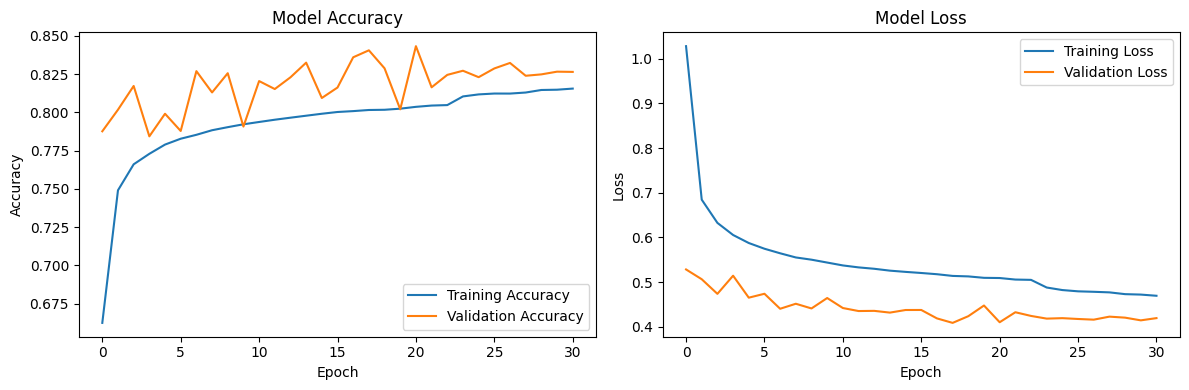

In [6]:
# Cell 6: Evaluate Model Performance and Class-wise Analysis
# Load best model
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Class-wise accuracy analysis
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("\nClassification Report:")
target_names = [char_mapping[i] for i in range(len(char_mapping))]
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Show per-class accuracy for some classes
from sklearn.metrics import accuracy_score
print("\nPer-class accuracy (sample):")
for i in range(min(20, len(np.unique(y_test)))):
    mask = y_test == i
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_pred_classes[mask])
        print(f"Class {i} ('{char_mapping[i]}'): {class_acc:.3f} ({np.sum(mask)} samples)")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


###Prprocessing Part


In [41]:

# Cell 14: Advanced Preprocessing for Better Character Distinction
def advanced_preprocess_image(image_path):
    """Enhanced preprocessing to better distinguish similar characters"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not read image")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Apply bilateral filter to reduce noise while preserving edges
    filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)

    # Apply adaptive threshold
    binary = cv2.adaptiveThreshold(
        filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Morphological operations to clean up
    kernel = np.ones((2,2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)

    return cleaned

def improved_character_extraction(image, bbox):
    """Improved character extraction with better normalization"""
    x, y, w, h = bbox

    # Extract character region with some padding
    pad = 5
    x_start = max(0, x - pad)
    y_start = max(0, y - pad)
    x_end = min(image.shape[1], x + w + pad)
    y_end = min(image.shape[0], y + h + pad)

    char_img = image[y_start:y_end, x_start:x_end]

    # Calculate aspect ratio
    aspect_ratio = w / h

    # Resize maintaining aspect ratio
    if aspect_ratio > 1:
        # Wider than tall
        new_w = 20
        new_h = int(20 / aspect_ratio)
    else:
        # Taller than wide
        new_h = 20
        new_w = int(20 * aspect_ratio)

    # Ensure minimum size
    new_w = max(new_w, 8)
    new_h = max(new_h, 8)

    resized = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Center in 28x28 image
    final_img = np.zeros((28, 28), dtype=np.uint8)
    start_x = (28 - new_w) // 2
    start_y = (28 - new_h) // 2
    final_img[start_y:start_y+new_h, start_x:start_x+new_w] = resized

    # Apply slight Gaussian blur to smooth edges
    final_img = cv2.GaussianBlur(final_img, (3, 3), 0.5)

    # Normalize
    normalized = final_img.astype('float32') / 255.0

    return normalized


# Modified segment_characters function with space detection
def segment_characters_with_spaces(binary_image):
    """Segment individual characters and detect spaces between words"""
    # Find contours
    contours, _ = cv2.findContours(
        binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter and sort contours
    character_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter small contours
            x, y, w, h = cv2.boundingRect(contour)
            # Filter based on aspect ratio and size
            if 0.2 < h/w < 5 and w > 10 and h > 10:
                character_contours.append((x, y, w, h))

    # Sort by x-coordinate (left to right)
    character_contours.sort(key=lambda x: x[0])

    if not character_contours:
        return []

    # Calculate spaces between characters
    segments_with_spaces = []

    for i, bbox in enumerate(character_contours):
        x, y, w, h = bbox

        # Add the current character
        segments_with_spaces.append(('char', bbox))

        # Check if we need to add a space after this character
        if i < len(character_contours) - 1:
            next_bbox = character_contours[i + 1]
            next_x = next_bbox[0]

            # Calculate distance between current character end and next character start
            current_end = x + w
            distance = next_x - current_end

            # Calculate average character width for dynamic threshold
            avg_char_width = np.mean([bbox[2] for bbox in character_contours])

            # Threshold for space detection (you can adjust this)
            space_threshold = avg_char_width * 0.8  # 80% of average character width

            # If distance is greater than threshold, add a space
            if distance > space_threshold:
                segments_with_spaces.append(('space', None))

    return segments_with_spaces

In [42]:
# Modified predict_with_confidence_analysis function with space detection
def predict_with_confidence_analysis(image_path, confidence_threshold=0.7):
    """Enhanced prediction with confidence analysis, suggestions and space detection"""
    try:
        # Use advanced preprocessing
        binary_img = advanced_preprocess_image(image_path)

        # Segment characters WITH SPACE DETECTION
        segments = segment_characters_with_spaces(binary_img)

        if not segments:
            print("No characters detected in the image")
            return ""

        predictions = []
        low_confidence_chars = []
        char_position = 0  # Track actual character positions (excluding spaces)

        # Count actual characters for plotting (exclude spaces)
        actual_chars = [seg for seg in segments if seg[0] == 'char']

        if actual_chars:
            plt.figure(figsize=(20, 8))

        for i, (seg_type, bbox) in enumerate(segments):
            if seg_type == 'space':
                # Add space to predictions with high confidence
                predictions.append((' ', 1.0, [' '], [1.0]))
                print(f"  Space detected at position {i}")
            else:
                # Process character
                char_img = improved_character_extraction(binary_img, bbox)

                # Predict
                char_input = char_img.reshape(1, 28, 28, 1)
                prediction = model.predict(char_input, verbose=0)

                # Get top 3 predictions
                top_3_indices = np.argsort(prediction[0])[-3:][::-1]
                top_3_probs = prediction[0][top_3_indices]
                top_3_chars = [char_mapping[idx] for idx in top_3_indices]

                predicted_char = top_3_chars[0]
                confidence = top_3_probs[0]

                predictions.append((predicted_char, confidence, top_3_chars, top_3_probs))

                # Check for low confidence
                if confidence < confidence_threshold:
                    low_confidence_chars.append({
                        'position': i,  # Overall position including spaces
                        'char_position': char_position,  # Character-only position
                        'char': predicted_char,
                        'confidence': confidence,
                        'alternatives': list(zip(top_3_chars, top_3_probs))
                    })

                # Visualize with top predictions (only for actual characters)
                plt.subplot(3, len(actual_chars), char_position + 1)
                plt.imshow(char_img, cmap='gray')
                if confidence < confidence_threshold:
                    plt.title(f'{predicted_char}\n{confidence:.2f}', color='red')
                else:
                    plt.title(f'{predicted_char}\n{confidence:.2f}')
                plt.axis('off')

                # Show top 3 predictions
                plt.subplot(3, len(actual_chars), len(actual_chars) + char_position + 1)
                y_pos = np.arange(3)
                plt.barh(y_pos, top_3_probs)
                plt.yticks(y_pos, top_3_chars)
                plt.xlabel('Confidence')
                plt.title('Top 3')

                # Show original region
                plt.subplot(3, len(actual_chars), 2*len(actual_chars) + char_position + 1)
                x, y, w, h = bbox
                original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                char_region = original_img[y:y+h, x:x+w]
                plt.imshow(char_region, cmap='gray')
                plt.title('Original')
                plt.axis('off')

                char_position += 1

        if actual_chars:
            plt.tight_layout()
            plt.show()

        # Print results
        predicted_text = ''.join([pred[0] for pred in predictions])
        # Calculate average confidence only for actual characters (exclude spaces)
        char_confidences = [pred[1] for pred in predictions if pred[0] != ' ']
        avg_confidence = np.mean(char_confidences) if char_confidences else 0

        print(f"Predicted text: '{predicted_text}'")
        print(f"Average confidence: {avg_confidence:.3f}")
        print(f"Total segments: {len(segments)} (Characters: {len(actual_chars)}, Spaces: {len(segments) - len(actual_chars)})")

        # Show low confidence warnings
        if low_confidence_chars:
            print(f"\n⚠️  LOW CONFIDENCE CHARACTERS ({len(low_confidence_chars)}):")
            for char_info in low_confidence_chars:
                pos = char_info['position']
                char_pos = char_info['char_position']
                char = char_info['char']
                conf = char_info['confidence']
                alts = char_info['alternatives']

                print(f"  Position {pos} (Char #{char_pos}): '{char}' (confidence: {conf:.2f})")
                print(f"    Alternatives: {', '.join([f'{c}({p:.2f})' for c, p in alts[1:]])}")

                # Specific suggestions for common confusions
                if char in ['M', 'm', 'w', 'W']:
                    print(f"    💡 M/m/w/W confusion detected. Check letter shape and size.")
                elif char in ['s', 'S', '5']:
                    print(f"    💡 s/S/5 confusion detected. Check curves and angles.")
                elif char in ['o', 'O', '0']:
                    print(f"    💡 o/O/0 confusion detected. Check size and thickness.")
                elif char in ['I', 'l', '1', 'T']:
                    print(f"    💡 I/l/1/T confusion detected. Check serifs and horizontal lines.")

        return predicted_text, predictions, low_confidence_chars

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return ""


Upload your handwritten image:


Saving WhatsApp Image 2025-06-13 at 19.25.50_38b283d9.jpg to WhatsApp Image 2025-06-13 at 19.25.50_38b283d9 (18).jpg
Processing image: WhatsApp Image 2025-06-13 at 19.25.50_38b283d9 (18).jpg


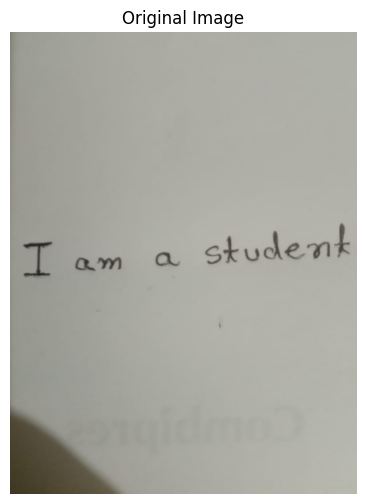


PROCESSING WITH 180° ROTATION
  Space detected at position 7
  Space detected at position 9
  Space detected at position 12


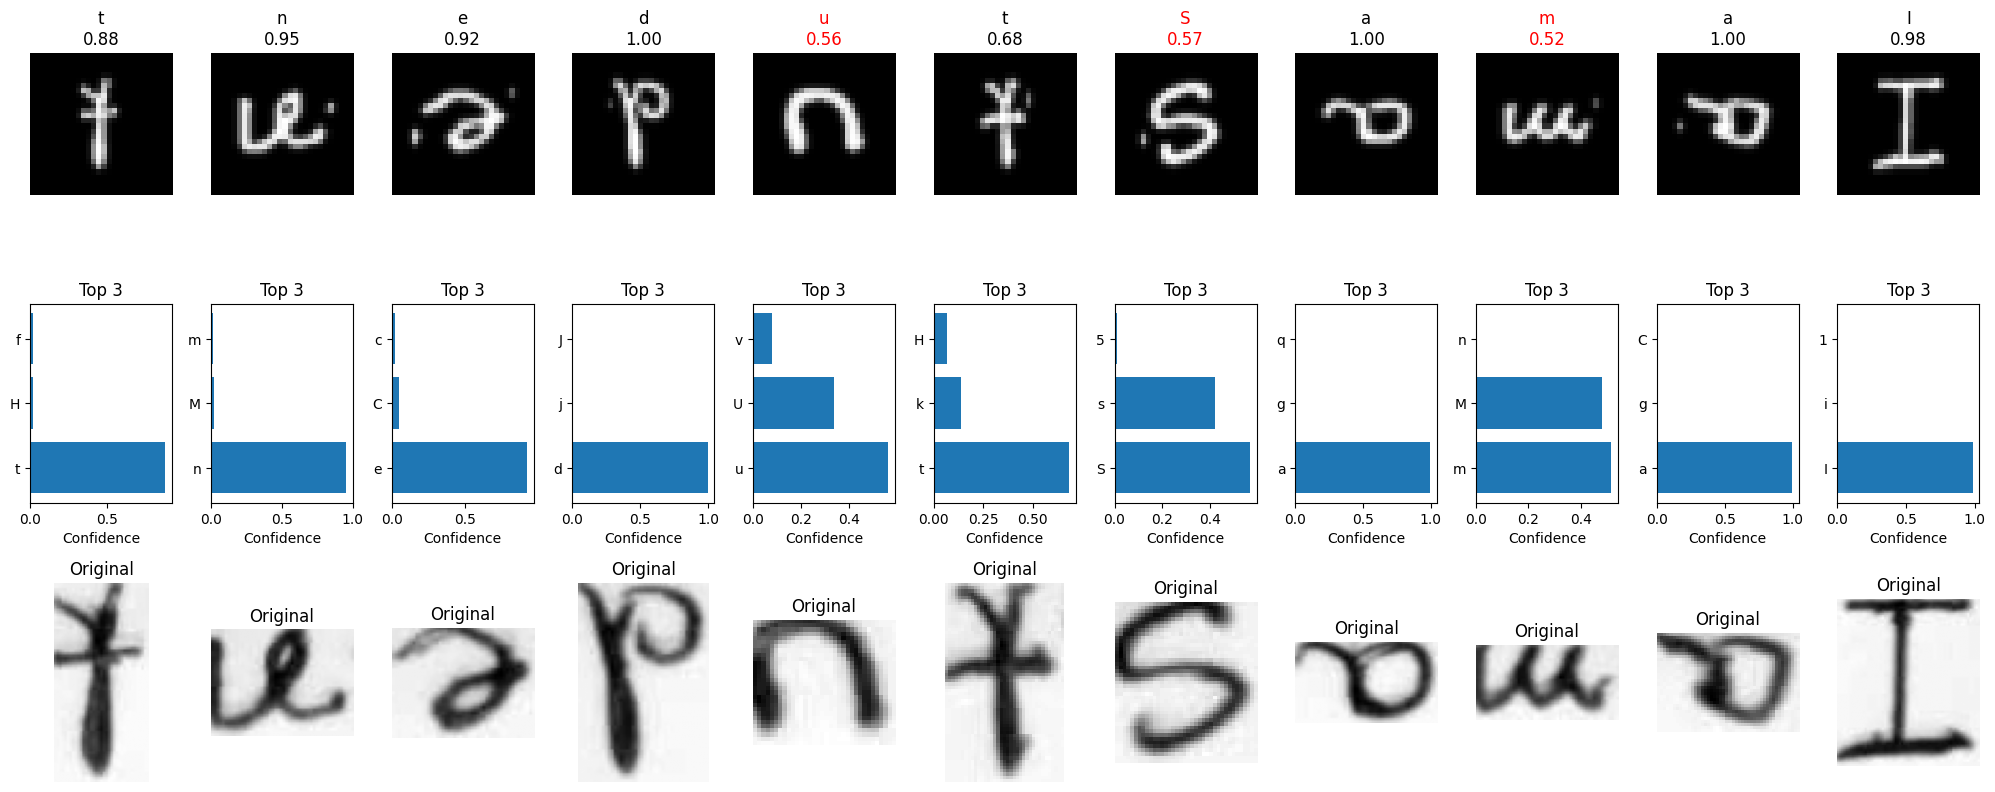

Predicted text: 'tnedutS a ma I'
Average confidence: 0.823
Total segments: 14 (Characters: 11, Spaces: 3)

⚠️  LOW CONFIDENCE CHARACTERS (3):
  Position 4 (Char #4): 'u' (confidence: 0.56)
    Alternatives: U(0.34), v(0.08)
  Position 6 (Char #6): 'S' (confidence: 0.57)
    Alternatives: s(0.42), 5(0.01)
    💡 s/S/5 confusion detected. Check curves and angles.
  Position 10 (Char #8): 'm' (confidence: 0.52)
    Alternatives: M(0.48), n(0.00)
    💡 M/m/w/W confusion detected. Check letter shape and size.
🏆 RESULT: 'I am a Student'
   Low confidence characters: 3


In [51]:
# Cell 9: Upload and Test Handwriting with Enhanced Analysis
print("Upload your handwritten image:")
uploaded = files.upload()

if uploaded:
    # Get the uploaded file name
    image_name = list(uploaded.keys())[0]
    print(f"Processing image: {image_name}")

    # Display the original image
    img = Image.open(io.BytesIO(uploaded[image_name]))
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Try rotation method
    print("\n" + "="*50)
    print("PROCESSING WITH 180° ROTATION")
    print("="*50)

    try:
        # Create rotated version using double flip (cleaner than warpAffine)
        original_img = cv2.imread(image_name)
        rotated_img = cv2.flip(cv2.flip(original_img, 0), 1)  # Flip both axes
        rotated_name = f"rotated_{image_name}"
        cv2.imwrite(rotated_name, rotated_img)

        result = predict_with_confidence_analysis(rotated_name, confidence_threshold=0.6)
        # result = predict_characters_with_spaces(image_name)
        if result:
            word, preds, low_conf = result
            reversed = word[::-1]
            print(f"🏆 RESULT: '{reversed}'")
            print(f"   Low confidence characters: {len(low_conf)}")
        else:
            print("❌ Processing failed. Try:")
            print("1. Better lighting")
            print("2. Clearer handwriting")
            print("3. Dark pen on white paper")
            print("4. Larger characters")

    except Exception as e:
        print(f"Processing failed: {e}")

    # Run detailed analysis on original image
    # print("\n--- DETAILED ANALYSIS (Original Image) ---")
    # analyze_predictions(image_name)

###TESTING

Upload your handwritten image:


Saving WhatsApp Image 2025-06-13 at 19.25.50_38b283d9.jpg to WhatsApp Image 2025-06-13 at 19.25.50_38b283d9 (6).jpg
Processing image: WhatsApp Image 2025-06-13 at 19.25.50_38b283d9 (6).jpg


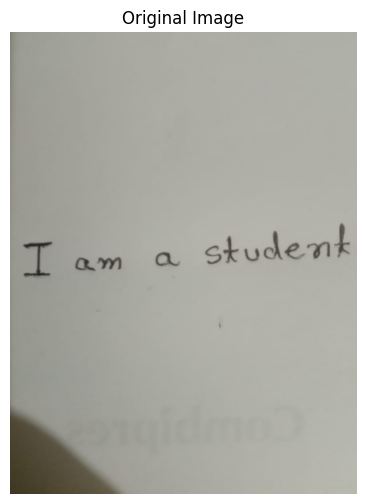


SPACE DETECTION ANALYSIS
Average character width: 46.9
Space threshold: 37.5
Space detected between character 0 and 1, distance: 50.0
Space detected between character 2 and 3, distance: 77.0
Space detected between character 3 and 4, distance: 55.0


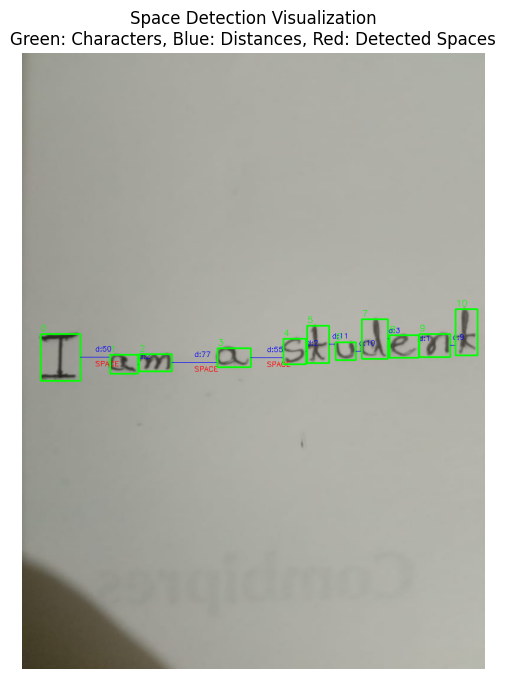


CHARACTER PREDICTION WITH SPACES


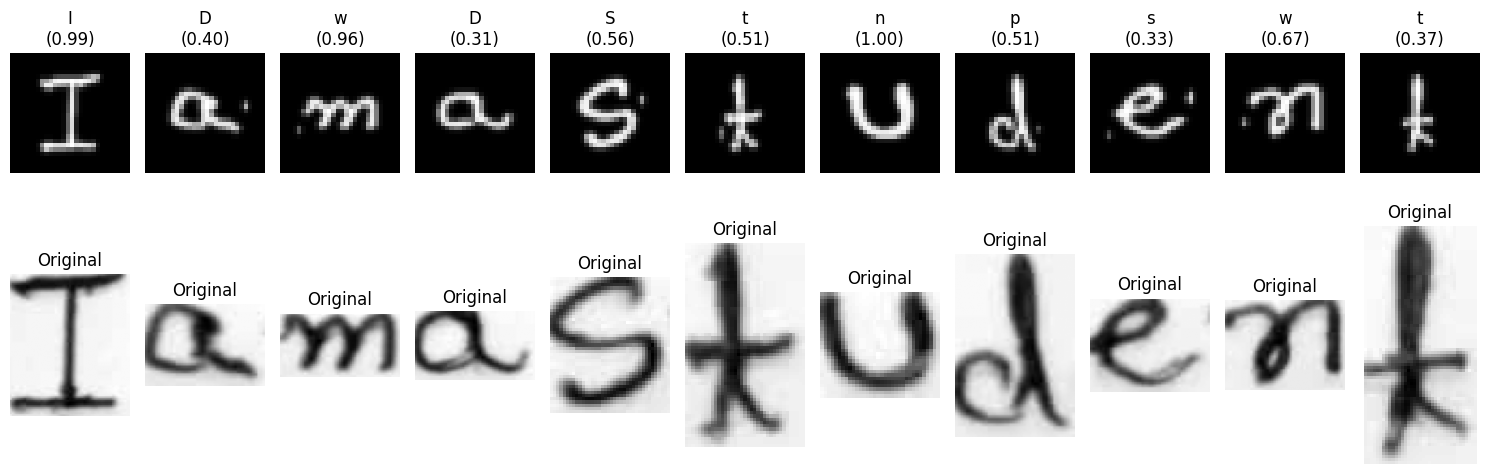

Predicted text: 'I Dw D Stnpswt'
Average confidence: 0.601
🏆 FINAL RESULT: 'I Dw D Stnpswt'


In [30]:
# # Modified segment_characters function with space detection
# def segment_characters_with_spaces(binary_image):
#     """Segment individual characters and detect spaces between words"""
#     # Find contours
#     contours, _ = cv2.findContours(
#         binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#     )

#     # Filter and sort contours
#     character_contours = []
#     for contour in contours:
#         area = cv2.contourArea(contour)
#         if area > 100:  # Filter small contours
#             x, y, w, h = cv2.boundingRect(contour)
#             # Filter based on aspect ratio and size
#             if 0.2 < h/w < 5 and w > 10 and h > 10:
#                 character_contours.append((x, y, w, h))

#     # Sort by x-coordinate (left to right)
#     character_contours.sort(key=lambda x: x[0])

#     if not character_contours:
#         return []

#     # Calculate spaces between characters
#     segments_with_spaces = []

#     for i, bbox in enumerate(character_contours):
#         x, y, w, h = bbox

#         # Add the current character
#         segments_with_spaces.append(('char', bbox))

#         # Check if we need to add a space after this character
#         if i < len(character_contours) - 1:
#             next_bbox = character_contours[i + 1]
#             next_x = next_bbox[0]

#             # Calculate distance between current character end and next character start
#             current_end = x + w
#             distance = next_x - current_end

#             # Calculate average character width for dynamic threshold
#             avg_char_width = np.mean([bbox[2] for bbox in character_contours])

#             # Threshold for space detection (you can adjust this)
#             space_threshold = avg_char_width * 0.8  # 80% of average character width

#             # If distance is greater than threshold, add a space
#             if distance > space_threshold:
#                 segments_with_spaces.append(('space', None))

#     return segments_with_spaces

# # Modified predict_characters function
# def predict_characters_with_spaces(image_path):
#     """Predict characters from handwritten text image with space detection"""
#     try:
#         # Preprocess image
#         binary_img = advanced_preprocess_image(image_path)

#         # Segment characters with space detection
#         segments = segment_characters_with_spaces(binary_img)

#         if not segments:
#             print("No characters detected in the image")
#             return ""

#         # Extract and predict each character
#         predictions = []
#         char_count = 0

#         # Count actual characters for plotting
#         actual_chars = [seg for seg in segments if seg[0] == 'char']

#         if actual_chars:
#             plt.figure(figsize=(15, 5))

#         for i, (seg_type, bbox) in enumerate(segments):
#             if seg_type == 'space':
#                 # Add space to predictions
#                 predictions.append((' ', 1.0))  # Space with confidence 1.0
#             else:
#                 # Process character
#                 char_img = improved_character_extraction(binary_img, bbox)

#                 # Predict
#                 char_input = char_img.reshape(1, 28, 28, 1)
#                 prediction = model.predict(char_input, verbose=0)
#                 predicted_class = np.argmax(prediction)
#                 confidence = np.max(prediction)

#                 predicted_char = char_mapping[predicted_class]
#                 predictions.append((predicted_char, confidence))

#                 # Visualize only actual characters
#                 plt.subplot(2, len(actual_chars), char_count + 1)
#                 plt.imshow(char_img, cmap='gray')
#                 plt.title(f'{predicted_char}\n({confidence:.2f})')
#                 plt.axis('off')

#                 # Show original region
#                 plt.subplot(2, len(actual_chars), len(actual_chars) + char_count + 1)
#                 x, y, w, h = bbox
#                 original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#                 char_region = original_img[y:y+h, x:x+w]
#                 plt.imshow(char_region, cmap='gray')
#                 plt.title('Original')
#                 plt.axis('off')

#                 char_count += 1

#         if actual_chars:
#             plt.tight_layout()
#             plt.show()

#         # Combine predictions
#         predicted_text = ''.join([pred[0] for pred in predictions])
#         char_confidences = [pred[1] for pred in predictions if pred[0] != ' ']
#         avg_confidence = np.mean(char_confidences) if char_confidences else 0

#         print(f"Predicted text: '{predicted_text}'")
#         print(f"Average confidence: {avg_confidence:.3f}")

#         return predicted_text, predictions

#     except Exception as e:
#         print(f"Error processing image: {str(e)}")
#         return ""

# # Alternative function with visualization of space detection
# def visualize_space_detection(image_path):
#     """Visualize how spaces are detected between characters"""
#     try:
#         # Preprocess image
#         binary_img = advanced_preprocess_image(image_path)

#         # Get original image for visualization
#         original_img = cv2.imread(image_path)
#         vis_img = original_img.copy()

#         # Get character contours (without space detection first)
#         contours, _ = cv2.findContours(
#             binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#         )

#         character_contours = []
#         for contour in contours:
#             area = cv2.contourArea(contour)
#             if area > 100:
#                 x, y, w, h = cv2.boundingRect(contour)
#                 if 0.2 < h/w < 5 and w > 10 and h > 10:
#                     character_contours.append((x, y, w, h))

#         character_contours.sort(key=lambda x: x[0])

#         if not character_contours:
#             print("No characters found")
#             return

#         # Calculate average character width
#         avg_char_width = np.mean([bbox[2] for bbox in character_contours])
#         space_threshold = avg_char_width * 0.8

#         print(f"Average character width: {avg_char_width:.1f}")
#         print(f"Space threshold: {space_threshold:.1f}")

#         # Draw bounding boxes and analyze distances
#         for i, bbox in enumerate(character_contours):
#             x, y, w, h = bbox

#             # Draw character bounding box in green
#             cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
#             cv2.putText(vis_img, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

#             # Check distance to next character
#             if i < len(character_contours) - 1:
#                 next_bbox = character_contours[i + 1]
#                 next_x = next_bbox[0]

#                 current_end = x + w
#                 distance = next_x - current_end

#                 # Draw distance line
#                 cv2.line(vis_img, (current_end, y + h//2), (next_x, y + h//2), (255, 0, 0), 1)

#                 # Add distance text
#                 mid_x = (current_end + next_x) // 2
#                 cv2.putText(vis_img, f'd:{distance:.0f}', (mid_x, y + h//2 - 10),
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

#                 # Mark if it's a space
#                 if distance > space_threshold:
#                     cv2.putText(vis_img, 'SPACE', (mid_x, y + h//2 + 15),
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
#                     print(f"Space detected between character {i} and {i+1}, distance: {distance:.1f}")

#         # Display result
#         plt.figure(figsize=(15, 8))
#         plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
#         plt.title("Space Detection Visualization\nGreen: Characters, Blue: Distances, Red: Detected Spaces")
#         plt.axis('off')
#         plt.show()

#     except Exception as e:
#         print(f"Error in visualization: {str(e)}")

# # Updated Cell 9 usage
# print("Upload your handwritten image:")
# uploaded = files.upload()

# if uploaded:
#     image_name = list(uploaded.keys())[0]
#     print(f"Processing image: {image_name}")

#     # Display the original image
#     img = Image.open(io.BytesIO(uploaded[image_name]))
#     plt.figure(figsize=(10, 6))
#     plt.imshow(img)
#     plt.title("Original Image")
#     plt.axis('off')
#     plt.show()

#     # Visualize space detection
#     print("\n" + "="*50)
#     print("SPACE DETECTION ANALYSIS")
#     print("="*50)
#     visualize_space_detection(image_name)

#     # Process with space detection
#     print("\n" + "="*50)
#     print("CHARACTER PREDICTION WITH SPACES")
#     print("="*50)
#     result = predict_characters_with_spaces(image_name)
#     if result:
#         predicted_text, predictions = result
#         print(f"🏆 FINAL RESULT: '{predicted_text}'")

Upload your handwritten image:


Saving WhatsApp Image 2025-06-09 at 18.03.50_0645bd76.jpg to WhatsApp Image 2025-06-09 at 18.03.50_0645bd76 (4).jpg
Processing image: WhatsApp Image 2025-06-09 at 18.03.50_0645bd76 (4).jpg


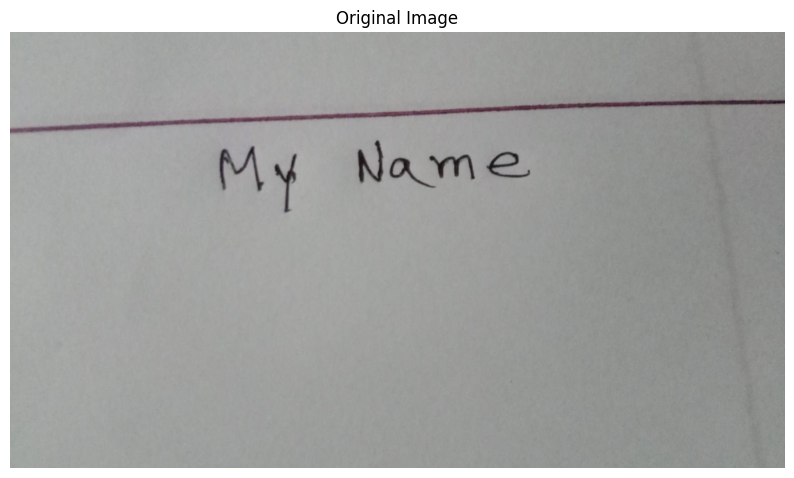


PROCESSING WITH 180° ROTATION AND SPACE DETECTION
  Space detected at position 4


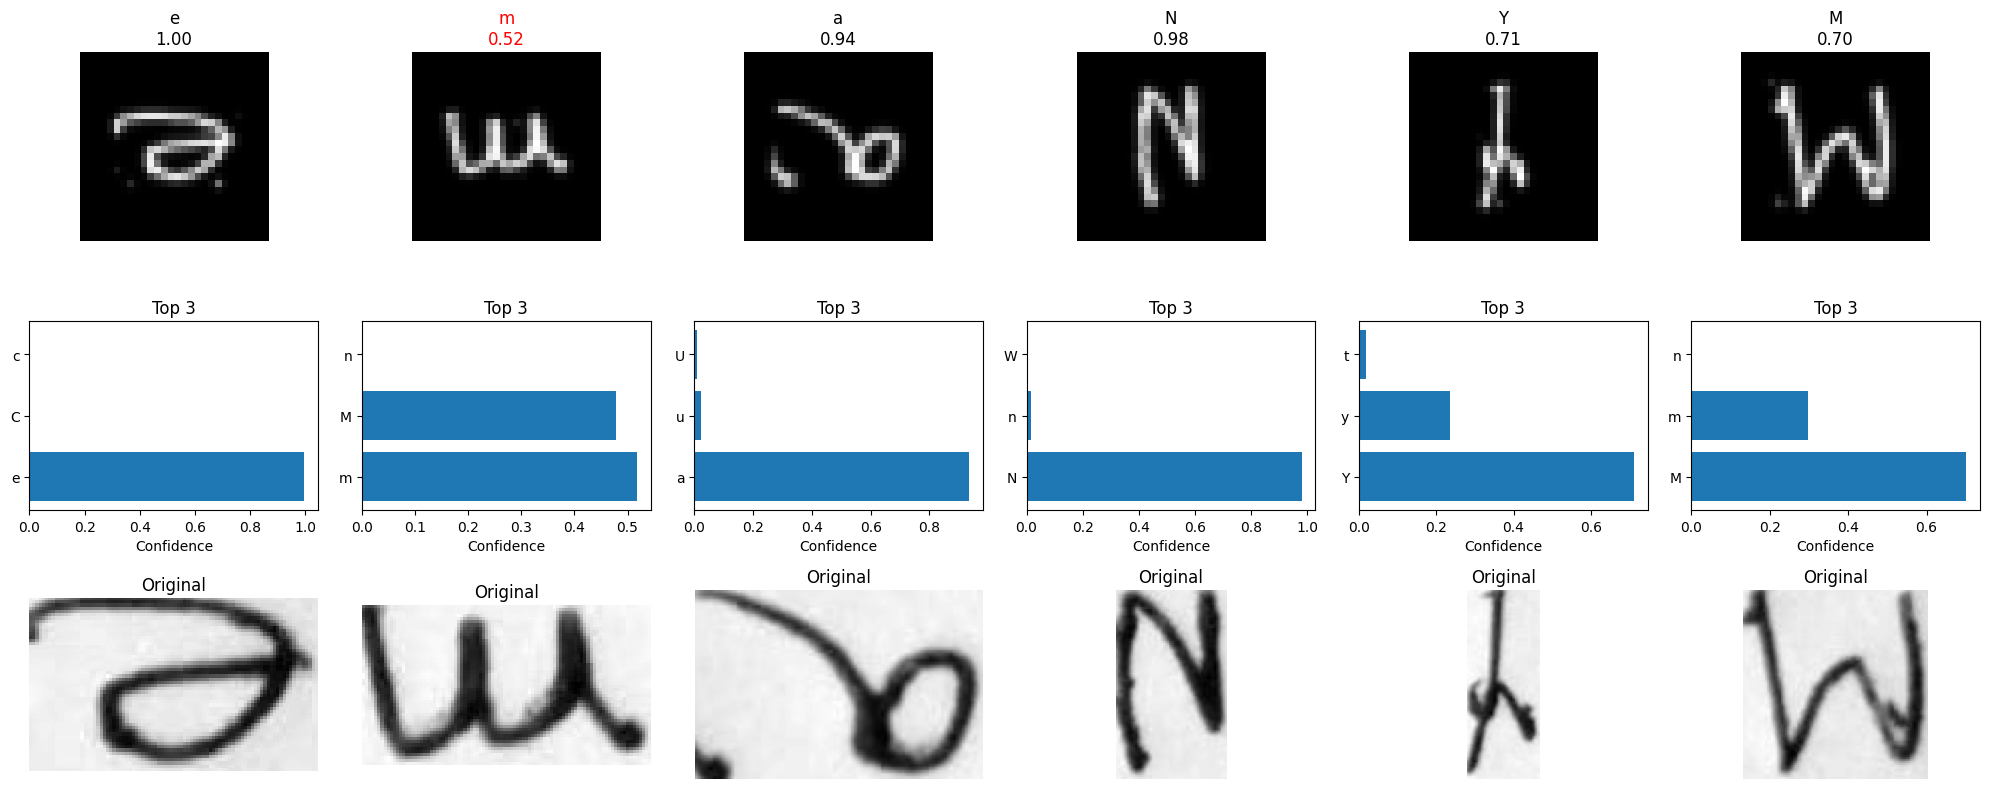

Predicted text: 'emaN YM'
Average confidence: 0.807
Total segments: 7 (Characters: 6, Spaces: 1)

⚠️  LOW CONFIDENCE CHARACTERS (1):
  Position 1 (Char #1): 'm' (confidence: 0.52)
    Alternatives: M(0.48), n(0.00)
    💡 M/m/w/W confusion detected. Check letter shape and size.
🏆 RESULT: 'emaN YM'
   Low confidence characters: 1

--- DETAILED ANALYSIS (Original Image) ---

📊 DETAILED ANALYSIS
--------------------------------------------------
🔍 Space Detection Analysis:
Average character width: 78.5
Space threshold: 62.8
Space detected between character 1 and 2, distance: 126.0


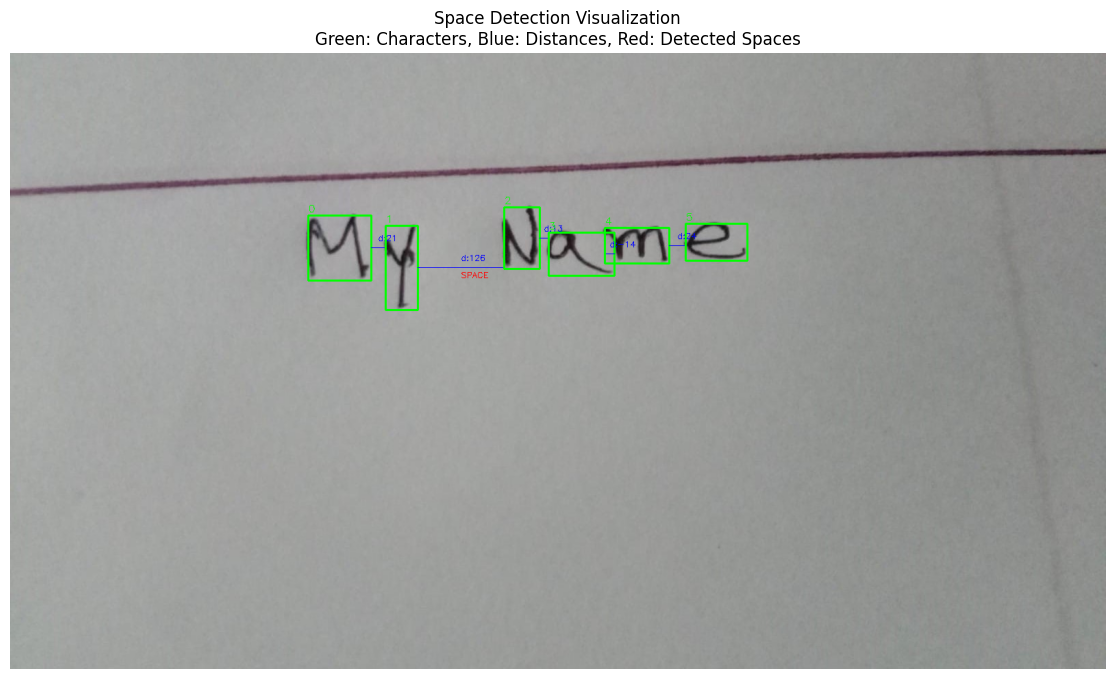


🎯 Confidence Analysis:
  Space detected at position 2


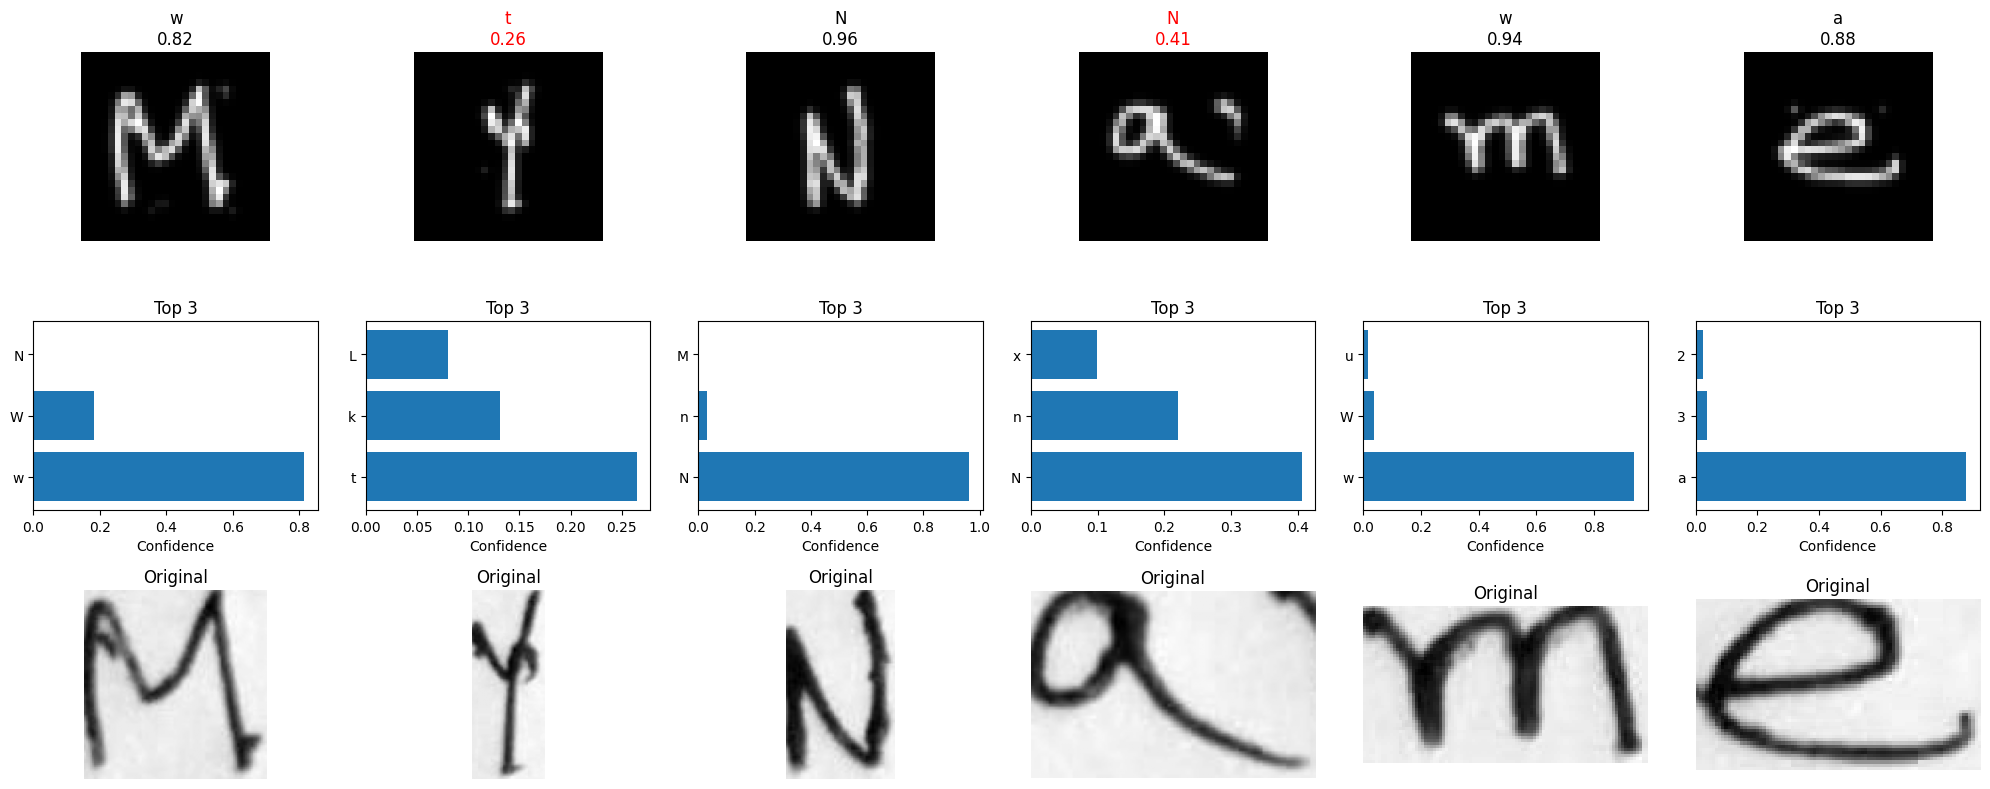

Predicted text: 'wt NNwa'
Average confidence: 0.711
Total segments: 7 (Characters: 6, Spaces: 1)

⚠️  LOW CONFIDENCE CHARACTERS (2):
  Position 1 (Char #1): 't' (confidence: 0.26)
    Alternatives: k(0.13), L(0.08)
  Position 4 (Char #3): 'N' (confidence: 0.41)
    Alternatives: n(0.22), x(0.10)

📝 Character-by-character breakdown:
   0: 'w' (conf: 0.816) - Alt: W(0.183)
   1: 't' (conf: 0.265) - Alt: k(0.131)
   2: [SPACE]
   3: 'N' (conf: 0.963) - Alt: n(0.030)
   4: 'N' (conf: 0.406) - Alt: n(0.221)
   5: 'w' (conf: 0.939) - Alt: W(0.037)
   6: 'a' (conf: 0.879) - Alt: 3(0.038)

🏆 Final Result: 'wt NNwa'
📈 Statistics: 6 characters, 1 spaces, 2 low confidence


In [40]:
# Modified predict_with_confidence_analysis function with space detection
def predict_with_confidence_analysis(image_path, confidence_threshold=0.7):
    """Enhanced prediction with confidence analysis, suggestions and space detection"""
    try:
        # Use advanced preprocessing
        binary_img = advanced_preprocess_image(image_path)

        # Segment characters WITH SPACE DETECTION
        segments = segment_characters_with_spaces(binary_img)

        if not segments:
            print("No characters detected in the image")
            return ""

        predictions = []
        low_confidence_chars = []
        char_position = 0  # Track actual character positions (excluding spaces)

        # Count actual characters for plotting (exclude spaces)
        actual_chars = [seg for seg in segments if seg[0] == 'char']

        if actual_chars:
            plt.figure(figsize=(20, 8))

        for i, (seg_type, bbox) in enumerate(segments):
            if seg_type == 'space':
                # Add space to predictions with high confidence
                predictions.append((' ', 1.0, [' '], [1.0]))
                print(f"  Space detected at position {i}")
            else:
                # Process character
                char_img = improved_character_extraction(binary_img, bbox)

                # Predict
                char_input = char_img.reshape(1, 28, 28, 1)
                prediction = model.predict(char_input, verbose=0)

                # Get top 3 predictions
                top_3_indices = np.argsort(prediction[0])[-3:][::-1]
                top_3_probs = prediction[0][top_3_indices]
                top_3_chars = [char_mapping[idx] for idx in top_3_indices]

                predicted_char = top_3_chars[0]
                confidence = top_3_probs[0]

                predictions.append((predicted_char, confidence, top_3_chars, top_3_probs))

                # Check for low confidence
                if confidence < confidence_threshold:
                    low_confidence_chars.append({
                        'position': i,  # Overall position including spaces
                        'char_position': char_position,  # Character-only position
                        'char': predicted_char,
                        'confidence': confidence,
                        'alternatives': list(zip(top_3_chars, top_3_probs))
                    })

                # Visualize with top predictions (only for actual characters)
                plt.subplot(3, len(actual_chars), char_position + 1)
                plt.imshow(char_img, cmap='gray')
                if confidence < confidence_threshold:
                    plt.title(f'{predicted_char}\n{confidence:.2f}', color='red')
                else:
                    plt.title(f'{predicted_char}\n{confidence:.2f}')
                plt.axis('off')

                # Show top 3 predictions
                plt.subplot(3, len(actual_chars), len(actual_chars) + char_position + 1)
                y_pos = np.arange(3)
                plt.barh(y_pos, top_3_probs)
                plt.yticks(y_pos, top_3_chars)
                plt.xlabel('Confidence')
                plt.title('Top 3')

                # Show original region
                plt.subplot(3, len(actual_chars), 2*len(actual_chars) + char_position + 1)
                x, y, w, h = bbox
                original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                char_region = original_img[y:y+h, x:x+w]
                plt.imshow(char_region, cmap='gray')
                plt.title('Original')
                plt.axis('off')

                char_position += 1

        if actual_chars:
            plt.tight_layout()
            plt.show()

        # Print results
        predicted_text = ''.join([pred[0] for pred in predictions])
        # Calculate average confidence only for actual characters (exclude spaces)
        char_confidences = [pred[1] for pred in predictions if pred[0] != ' ']
        avg_confidence = np.mean(char_confidences) if char_confidences else 0

        print(f"Predicted text: '{predicted_text}'")
        print(f"Average confidence: {avg_confidence:.3f}")
        print(f"Total segments: {len(segments)} (Characters: {len(actual_chars)}, Spaces: {len(segments) - len(actual_chars)})")

        # Show low confidence warnings
        if low_confidence_chars:
            print(f"\n⚠️  LOW CONFIDENCE CHARACTERS ({len(low_confidence_chars)}):")
            for char_info in low_confidence_chars:
                pos = char_info['position']
                char_pos = char_info['char_position']
                char = char_info['char']
                conf = char_info['confidence']
                alts = char_info['alternatives']

                print(f"  Position {pos} (Char #{char_pos}): '{char}' (confidence: {conf:.2f})")
                print(f"    Alternatives: {', '.join([f'{c}({p:.2f})' for c, p in alts[1:]])}")

                # Specific suggestions for common confusions
                if char in ['M', 'm', 'w', 'W']:
                    print(f"    💡 M/m/w/W confusion detected. Check letter shape and size.")
                elif char in ['s', 'S', '5']:
                    print(f"    💡 s/S/5 confusion detected. Check curves and angles.")
                elif char in ['o', 'O', '0']:
                    print(f"    💡 o/O/0 confusion detected. Check size and thickness.")
                elif char in ['I', 'l', '1', 'T']:
                    print(f"    💡 I/l/1/T confusion detected. Check serifs and horizontal lines.")

        return predicted_text, predictions, low_confidence_chars

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return ""

# Enhanced analyze_predictions function to work with spaces
def analyze_predictions(image_path):
    """Analyze predictions with detailed breakdown including spaces"""
    print("\n📊 DETAILED ANALYSIS")
    print("-" * 50)

    # First show space detection visualization
    print("🔍 Space Detection Analysis:")
    visualize_space_detection(image_path)

    # Then run confidence analysis
    print("\n🎯 Confidence Analysis:")
    result = predict_with_confidence_analysis(image_path, confidence_threshold=0.6)

    if result:
        predicted_text, predictions, low_conf = result

        print(f"\n📝 Character-by-character breakdown:")
        for i, (char, conf, top3_chars, top3_probs) in enumerate(predictions):
            if char == ' ':
                print(f"  {i:2d}: [SPACE]")
            else:
                print(f"  {i:2d}: '{char}' (conf: {conf:.3f}) - Alt: {top3_chars[1] if len(top3_chars) > 1 else 'None'}({top3_probs[1]:.3f})")

        print(f"\n🏆 Final Result: '{predicted_text}'")

        # Additional analysis
        total_chars = len([p for p in predictions if p[0] != ' '])
        total_spaces = len([p for p in predictions if p[0] == ' '])
        print(f"📈 Statistics: {total_chars} characters, {total_spaces} spaces, {len(low_conf)} low confidence")

        return predicted_text
    else:
        print("❌ Analysis failed")
        return None

# Updated Cell 9 with space detection
print("Upload your handwritten image:")
uploaded = files.upload()

if uploaded:
    # Get the uploaded file name
    image_name = list(uploaded.keys())[0]
    print(f"Processing image: {image_name}")

    # Display the original image
    img = Image.open(io.BytesIO(uploaded[image_name]))
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Try rotation method with space detection
    print("\n" + "="*50)
    print("PROCESSING WITH 180° ROTATION AND SPACE DETECTION")
    print("="*50)

    try:
        # Create rotated version using double flip (cleaner than warpAffine)
        original_img = cv2.imread(image_name)
        rotated_img = cv2.flip(cv2.flip(original_img, 0), 1)  # Flip both axes
        rotated_name = f"rotated_{image_name}"
        cv2.imwrite(rotated_name, rotated_img)

        result = predict_with_confidence_analysis(rotated_name, confidence_threshold=0.6)
        if result:
            text, preds, low_conf = result
            print(f"🏆 RESULT: '{text}'")
            print(f"   Low confidence characters: {len(low_conf)}")
        else:
            print("❌ Processing failed. Try:")
            print("1. Better lighting")
            print("2. Clearer handwriting")
            print("3. Dark pen on white paper")
            print("4. Larger characters")

    except Exception as e:
        print(f"Processing failed: {e}")

    # Run detailed analysis on original image
    print("\n--- DETAILED ANALYSIS (Original Image) ---")
    analyze_predictions(image_name)

###LESS USED CODE


In [19]:
# Cell 10: Test with Multiple Images (Optional)
def test_multiple_images():
    """Function to test multiple images"""
    print("Upload multiple images to test:")
    uploaded_files = files.upload()

    results = {}
    for filename in uploaded_files.keys():
        print(f"\n--- Processing {filename} ---")
        try:
            result = predict_characters(filename)
            results[filename] = result
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            results[filename] = None

    return results

# Uncomment the line below if you want to test multiple images
# test_results = test_multiple_images()

In [47]:
# # Cell 12: Performance Analysis and Debugging
# def analyze_predictions(image_path):
#     """Detailed analysis of predictions with debugging info"""
#     print("=== Detailed Analysis ===")

#     # Show preprocessing steps
#     original = cv2.imread(image_path)
#     gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
#     binary = advanced_preprocess_image(image_path)

#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
#     axes[0].set_title('Original')
#     axes[0].axis('off')

#     axes[1].imshow(gray, cmap='gray')
#     axes[1].set_title('Grayscale')
#     axes[1].axis('off')

#     axes[2].imshow(binary, cmap='gray')
#     axes[2].set_title('Binary/Processed')
#     axes[2].axis('off')

#     plt.tight_layout()
#     plt.show()

#     # Show segmentation
#     char_bboxes = segment_characters_with_spaces(binary)
#     img_with_boxes = original.copy()

#     for i, (x, y, w, h) in enumerate(char_bboxes):
#         cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
#         cv2.putText(img_with_boxes, str(i), (x, y-10),
#                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

#     plt.figure(figsize=(12, 6))
#     plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
#     plt.title(f'Character Segmentation - {len(char_bboxes)} characters detected')
#     plt.axis('off')
#     plt.show()

#     print(f"Detected {len(char_bboxes)} character regions")
# Cell 12: Performance Analysis and Debugging - FIXED VERSION
def analyze_predictions(image_path):
    """Detailed analysis of predictions with debugging info and space detection"""
    print("=== Detailed Analysis ===")

    # Show preprocessing steps
    original = cv2.imread(image_path)
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    binary = advanced_preprocess_image(image_path)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(gray, cmap='gray')
    axes[1].set_title('Grayscale')
    axes[1].axis('off')

    axes[2].imshow(binary, cmap='gray')
    axes[2].set_title('Binary/Processed')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Show segmentation WITH SPACE DETECTION
    segments = segment_characters_with_spaces(binary)
    img_with_boxes = original.copy()

    # Extract only character segments for visualization
    char_segments = []
    space_positions = []

    for i, (seg_type, bbox) in enumerate(segments):
        if seg_type == 'char':
            char_segments.append((i, bbox))
        else:  # space
            space_positions.append(i)

    # Draw bounding boxes for characters only
    for char_idx, (original_idx, bbox) in enumerate(char_segments):
        x, y, w, h = bbox
        cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_with_boxes, f'C{char_idx}', (x, y-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Show space detection visualization
    plt.figure(figsize=(15, 8))

    # Top subplot: Character segmentation
    plt.subplot(2, 1, 1)
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title(f'Character Segmentation - {len(char_segments)} characters detected')
    plt.axis('off')

    # Bottom subplot: Space detection visualization
    plt.subplot(2, 1, 2)

    # Create a visualization showing character positions and spaces
    if char_segments:
        # Get character positions for space visualization
        char_positions = []
        for _, bbox in char_segments:
            x, y, w, h = bbox
            char_positions.append((x, x + w))  # start and end x positions

        # Calculate average character width for threshold
        char_widths = [bbox[2] for _, bbox in char_segments]
        avg_char_width = np.mean(char_widths)
        space_threshold = avg_char_width * 0.8

        # Create space detection plot
        y_pos = 0.5
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

        # Plot characters
        for i, (start_x, end_x) in enumerate(char_positions):
            plt.barh(y_pos, end_x - start_x, left=start_x, height=0.3,
                    color=colors[i % len(colors)], alpha=0.7, label=f'Char {i}')
            plt.text(start_x + (end_x - start_x)/2, y_pos, f'C{i}',
                    ha='center', va='center', fontweight='bold')

        # Show distances and mark spaces
        for i in range(len(char_positions) - 1):
            current_end = char_positions[i][1]
            next_start = char_positions[i + 1][0]
            distance = next_start - current_end

            # Draw distance line
            mid_x = (current_end + next_start) / 2
            plt.annotate(f'd={distance:.0f}', xy=(mid_x, y_pos + 0.2),
                        ha='center', fontsize=8)

            # Mark if it's a space
            if distance > space_threshold:
                plt.annotate('SPACE', xy=(mid_x, y_pos - 0.2),
                           ha='center', fontsize=10, color='red', fontweight='bold')
                plt.axvline(x=mid_x, color='red', linestyle='--', alpha=0.5)

        plt.xlim(0, original.shape[1])
        plt.ylim(0, 1)
        plt.title(f'Space Detection Analysis (Threshold: {space_threshold:.1f}px)')
        plt.xlabel('X Position (pixels)')
        plt.ylabel('')
        plt.yticks([])

    plt.tight_layout()
    plt.show()

    # Print detailed segment information
    print(f"\nDetected {len(segments)} total segments:")
    print(f"  - Characters: {len(char_segments)}")
    print(f"  - Spaces: {len(space_positions)}")

    print(f"\nSegment breakdown:")
    for i, (seg_type, bbox) in enumerate(segments):
        if seg_type == 'char':
            x, y, w, h = bbox
            print(f"  {i:2d}: Character at ({x}, {y}) size {w}x{h}")
        else:
            print(f"  {i:2d}: Space detected")

    # Run the actual prediction
    print(f"\n" + "="*50)
    print("RUNNING PREDICTION WITH CONFIDENCE ANALYSIS")
    print("="*50)

    result = predict_with_confidence_analysis(image_path, confidence_threshold=0.6)

    if result:
        predicted_text, predictions, low_conf = result
        print(f"\n🎯 Character-by-character breakdown:")
        for i, (char, conf, top3_chars, top3_probs) in enumerate(predictions):
            if char == ' ':
                print(f"  {i:2d}: [SPACE]")
            else:
                alt_char = top3_chars[1] if len(top3_chars) > 1 else 'None'
                alt_conf = top3_probs[1] if len(top3_probs) > 1 else 0
                print(f"  {i:2d}: '{char}' (conf: {conf:.3f}) - Alt: '{alt_char}'({alt_conf:.3f})")

        print(f"\n🏆 Final Result: '{predicted_text}'")
        return predicted_text
    else:
        print("❌ Prediction failed")
        return None

# Alternative version that shows BOTH old and new segmentation for comparison
def compare_segmentation_methods(image_path):
    """Compare old character-only segmentation vs new space-aware segmentation"""
    print("=== SEGMENTATION COMPARISON ===")

    binary = advanced_preprocess_image(image_path)
    original = cv2.imread(image_path)

    # Old method (characters only)
    old_segments = segment_characters(binary)  # Your original function

    # New method (with spaces)
    new_segments = segment_characters_with_spaces(binary)
    char_only_new = [bbox for seg_type, bbox in new_segments if seg_type == 'char']

    # Visualize both
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Old method visualization
    img1 = original.copy()
    for i, bbox in enumerate(old_segments):
        x, y, w, h = bbox
        cv2.rectangle(img1, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Blue boxes
        cv2.putText(img1, str(i), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Old Method: {len(old_segments)} characters (no space detection)')
    axes[0].axis('off')

    # New method visualization
    img2 = original.copy()
    for i, bbox in enumerate(char_only_new):
        x, y, w, h = bbox
        cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Green boxes
        cv2.putText(img2, str(i), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'New Method: {len(char_only_new)} characters + {len(new_segments) - len(char_only_new)} spaces')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Old method result: {''.join([chr(ord('A') + i) for i in range(len(old_segments))])}")
    print(f"New method segments: {len(new_segments)} total ({len(char_only_new)} chars + {len(new_segments) - len(char_only_new)} spaces)")

In [17]:

# Cell 13: Handle Ambiguous Character Recognition
def analyze_confusing_pairs():
    """Analyze performance on commonly confused character pairs"""
    confusing_pairs = [
        ('M', 'm', 'w', 'W'),  # M/m/w/W confusion
        ('s', 'S', '5'),       # s/S/5 confusion
        ('T', 'I', 'l', '1'),  # T/I/l/1 confusion
        ('y', 'g'),            # y/g confusion
        ('o', 'O', '0'),       # o/O/0 confusion
        ('u', 'v'),            # u/v confusion
        ('b', '6'),            # b/6 confusion
        ('q', 'g', 'p'),       # q/g/p confusion
        ('rn', 'm'),           # rn vs m confusion
        ('cl', 'd'),           # cl vs d confusion
    ]

    print("=== CONFUSING CHARACTER PAIRS ANALYSIS ===")

    # Get predictions for test set
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Create reverse mapping
    char_to_idx = {char: idx for idx, char in enumerate(char_mapping)}

    for pair in confusing_pairs:
        print(f"\n--- Analyzing: {' vs '.join(pair)} ---")

        # Get indices for this pair
        pair_indices = []
        for char in pair:
            if char in char_to_idx:
                pair_indices.append(char_to_idx[char])

        if not pair_indices:
            print("Characters not found in dataset")
            continue

        # Analyze confusion between these characters
        for i, true_idx in enumerate(pair_indices):
            true_char = char_mapping[true_idx]
            mask = y_test == true_idx

            if np.sum(mask) > 0:
                predictions_for_class = y_pred_classes[mask]
                correct = np.sum(predictions_for_class == true_idx)
                total = len(predictions_for_class)
                accuracy = correct / total

                print(f"  {true_char}: {accuracy:.3f} accuracy ({correct}/{total})")

                # Show what it gets confused with
                confused_with = {}
                for pred in predictions_for_class:
                    if pred != true_idx and pred in pair_indices:
                        confused_char = char_mapping[pred]
                        confused_with[confused_char] = confused_with.get(confused_char, 0) + 1

                if confused_with:
                    for conf_char, count in confused_with.items():
                        print(f"    → Confused with '{conf_char}': {count} times ({count/total:.1%})")

# Run the analysis
analyze_confusing_pairs()

=== CONFUSING CHARACTER PAIRS ANALYSIS ===

--- Analyzing: M vs m vs w vs W ---
  M: 0.500 accuracy (743/1485)
    → Confused with 'm': 735 times (49.5%)
  m: 0.787 accuracy (365/464)
    → Confused with 'M': 98 times (21.1%)
  w: 0.912 accuracy (426/467)
    → Confused with 'W': 36 times (7.7%)
    → Confused with 'm': 2 times (0.4%)
  W: 0.636 accuracy (513/806)
    → Confused with 'w': 287 times (35.6%)

--- Analyzing: s vs S vs 5 ---
  s: 0.297 accuracy (130/437)
    → Confused with 'S': 279 times (63.8%)
    → Confused with '5': 14 times (3.2%)
  S: 0.821 accuracy (2879/3508)
    → Confused with 's': 473 times (13.5%)
    → Confused with '5': 128 times (3.6%)
  5: 0.931 accuracy (4830/5190)
    → Confused with 'S': 251 times (4.8%)
    → Confused with 's': 61 times (1.2%)

--- Analyzing: T vs I vs l vs 1 ---
  T: 0.964 accuracy (1519/1576)
  I: 0.613 accuracy (1256/2048)
    → Confused with '1': 403 times (19.7%)
    → Confused with 'l': 289 times (14.1%)
    → Confused with 'T': 

### FINE TUNING PART

In [ ]:
# Cell 16: Tips for Writing Clear Characters
def print_writing_tips():
    """Print tips for avoiding character confusion"""
    print("""
📝 WRITING TIPS TO AVOID CHARACTER CONFUSION:

🔤 M vs m vs w vs W:
   • M: Make vertical lines clearly separated, with a sharp peak
   • m: Keep the humps rounded and connected to the base line
   • w: Make it clearly wider than other letters, with pointed bottom
   • W: Use straight lines, make it wide and angular

🔢 s vs S vs 5:
   • s: Keep curves smooth and flowing
   • S: Make it larger with more pronounced curves
   • 5: Add the horizontal line at the top clearly

🔤 T vs I vs l vs 1:
   • T: Make the horizontal line clearly cross the vertical line
   • I: Add serifs (small horizontal lines) at top and bottom
   • l: Keep it simple and straight
   • 1: Add a clear angled stroke at the top

🔤 y vs g:
   • y: Make the tail go straight down
   • g: Make the loop clear and round

🔢 o vs O vs 0:
   • o: Keep it small and round
   • O: Make it larger and more oval
   • 0: Make it taller and sometimes add a slash

GENERAL TIPS:
✓ Write larger characters (at least 1cm tall)
✓ Leave clear spaces between characters
✓ Use consistent letter sizes
✓ Write on lined paper for better alignment
✓ Use dark pen on white paper
✓ Ensure good lighting when photographing
✓ Hold camera steady and take photo straight-on
    """)

# Run tips
print_writing_tips()


📝 WRITING TIPS TO AVOID CHARACTER CONFUSION:

🔤 M vs m vs w vs W:
   • M: Make vertical lines clearly separated, with a sharp peak
   • m: Keep the humps rounded and connected to the base line
   • w: Make it clearly wider than other letters, with pointed bottom
   • W: Use straight lines, make it wide and angular

🔢 s vs S vs 5:
   • s: Keep curves smooth and flowing
   • S: Make it larger with more pronounced curves
   • 5: Add the horizontal line at the top clearly

🔤 T vs I vs l vs 1:
   • T: Make the horizontal line clearly cross the vertical line
   • I: Add serifs (small horizontal lines) at top and bottom
   • l: Keep it simple and straight
   • 1: Add a clear angled stroke at the top

🔤 y vs g:
   • y: Make the tail go straight down
   • g: Make the loop clear and round

🔢 o vs O vs 0:
   • o: Keep it small and round
   • O: Make it larger and more oval
   • 0: Make it taller and sometimes add a slash

GENERAL TIPS:
✓ Write larger characters (at least 1cm tall)
✓ Leave clear 

In [ ]:
# Cell 17: Fine-tuning with Own Data
def create_fine_tuning_dataset():
    """Create dataset from handwriting for fine-tuning"""
    print("=== FINE-TUNING SETUP ===")
    print("This will help you create a custom dataset from your handwriting")

    # Upload multiple images for fine-tuning
    print("Upload multiple images of your handwriting (each should contain single characters or words):")
    uploaded_files = files.upload()

    custom_data = []
    custom_labels = []

    for filename in uploaded_files.keys():
        print(f"\n--- Processing {filename} ---")

        # Show image
        img = Image.open(io.BytesIO(uploaded_files[filename]))
        plt.figure(figsize=(8, 4))
        plt.imshow(img)
        plt.title(f"Image: {filename}")
        plt.axis('off')
        plt.show()

        # Get characters in this image
        actual_text = input(f"What text is written in {filename}? (enter character by character, e.g., 'Hello'): ")

        # Process image and segment characters
        try:
            binary_img = advanced_preprocess_image(filename)
            char_bboxes = segment_characters(binary_img)

            print(f"Detected {len(char_bboxes)} characters, you entered {len(actual_text)} characters")

            if len(char_bboxes) == len(actual_text):
                # Extract each character
                for i, (bbox, true_char) in enumerate(zip(char_bboxes, actual_text)):
                    if true_char in [char_mapping[j] for j in range(len(char_mapping))]:
                        char_img = improved_character_extraction(binary_img, bbox)
                        custom_data.append(char_img)

                        # Find label index
                        label_idx = char_mapping.index(true_char)
                        custom_labels.append(label_idx)

                        # Show extracted character
                        plt.figure(figsize=(2, 2))
                        plt.imshow(char_img, cmap='gray')
                        plt.title(f"'{true_char}'")
                        plt.axis('off')
                        plt.show()

                        print(f"Added '{true_char}' to fine-tuning dataset")
                    else:
                        print(f"Character '{true_char}' not in training set, skipping")
            else:
                print("⚠️ Mismatch between detected and actual characters. Skipping this image.")
                print("Try: 1) Write characters with more spacing, 2) Use clearer handwriting")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    if custom_data:
        # Convert to numpy arrays
        X_custom = np.array(custom_data)
        y_custom = np.array(custom_labels)

        print(f"\n✅ Created custom dataset with {len(custom_data)} samples")
        print(f"Characters collected: {[char_mapping[i] for i in y_custom]}")

        return X_custom, y_custom
    else:
        print("❌ No custom data collected")
        return None, None

def fine_tune_model(X_custom, y_custom, learning_rate=0.0001, epochs=10):
    """Fine-tune the model with your custom data"""
    if X_custom is None or len(X_custom) == 0:
        print("No custom data to fine-tune with!")
        return

    print(f"\n=== FINE-TUNING WITH {len(X_custom)} CUSTOM SAMPLES ===")

    # Create a copy of the model for fine-tuning
    fine_tune_model = tf.keras.models.clone_model(model)
    fine_tune_model.set_weights(model.get_weights())

    # Use lower learning rate for fine-tuning
    fine_tune_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data augmentation for custom data
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0
    )

    # Augment custom data
    X_custom_aug = []
    y_custom_aug = []

    for i in range(len(X_custom)):
        # Original sample
        X_custom_aug.append(X_custom[i])
        y_custom_aug.append(y_custom[i])

        # Generate 5 augmented versions
        img_reshaped = X_custom[i].reshape(1, 28, 28, 1)
        aug_iter = datagen.flow(img_reshaped, batch_size=1)

        for j in range(5):
            aug_img = next(aug_iter)[0]
            X_custom_aug.append(aug_img.reshape(28, 28))
            y_custom_aug.append(y_custom[i])

    X_custom_aug = np.array(X_custom_aug).reshape(-1, 28, 28, 1)
    y_custom_aug = np.array(y_custom_aug)

    print(f"Augmented dataset: {len(X_custom_aug)} samples")

    # Fine-tune
    history = fine_tune_model.fit(
        X_custom_aug, y_custom_aug,
        batch_size=32,
        epochs=epochs,
        verbose=1,
        validation_split=0.2 if len(X_custom_aug) > 10 else 0
    )

    # Save fine-tuned model
    fine_tune_model.save('fine_tuned_model.h5')
    print("✅ Fine-tuned model saved as 'fine_tuned_model.h5'")

    # Update global model
    global model
    model = fine_tune_model

    return fine_tune_model

SyntaxError: name 'model' is used prior to global declaration (<ipython-input-43-1704287004>, line 144)

testing fine tuning 2


In [ ]:
# Cell 17: Fine-tuning with Your Own Data
def create_fine_tuning_dataset():
    """Create dataset from your handwriting for fine-tuning"""
    print("=== FINE-TUNING SETUP ===")
    print("This will help you create a custom dataset from your handwriting")

    # Upload multiple images for fine-tuning
    print("Upload multiple images of your handwriting (each should contain single characters or words):")
    uploaded_files = files.upload()

    custom_data = []
    custom_labels = []

    for filename in uploaded_files.keys():
        print(f"\n--- Processing {filename} ---")

        # Show image
        img = Image.open(io.BytesIO(uploaded_files[filename]))
        plt.figure(figsize=(8, 4))
        plt.imshow(img)
        plt.title(f"Image: {filename}")
        plt.axis('off')
        plt.show()

        # Get characters in this image
        actual_text = input(f"What text is written in {filename}? (enter character by character, e.g., 'Hello'): ")

        # Process image and segment characters
        try:
            binary_img = advanced_preprocess_image(filename)
            char_bboxes = segment_characters(binary_img)

            print(f"Detected {len(char_bboxes)} characters, you entered {len(actual_text)} characters")

            if len(char_bboxes) == len(actual_text):
                # Extract each character
                for i, (bbox, true_char) in enumerate(zip(char_bboxes, actual_text)):
                    if true_char in [char_mapping[j] for j in range(len(char_mapping))]:
                        char_img = improved_character_extraction(binary_img, bbox)
                        custom_data.append(char_img)

                        # Find label index
                        label_idx = char_mapping.index(true_char)
                        custom_labels.append(label_idx)

                        # Show extracted character
                        plt.figure(figsize=(2, 2))
                        plt.imshow(char_img, cmap='gray')
                        plt.title(f"'{true_char}'")
                        plt.axis('off')
                        plt.show()

                        print(f"Added '{true_char}' to fine-tuning dataset")
                    else:
                        print(f"Character '{true_char}' not in training set, skipping")
            else:
                print("⚠️ Mismatch between detected and actual characters. Skipping this image.")
                print("Try: 1) Write characters with more spacing, 2) Use clearer handwriting")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    if custom_data:
        # Convert to numpy arrays
        X_custom = np.array(custom_data)
        y_custom = np.array(custom_labels)

        print(f"\n✅ Created custom dataset with {len(custom_data)} samples")
        print(f"Characters collected: {[char_mapping[i] for i in y_custom]}")

        return X_custom, y_custom
    else:
        print("❌ No custom data collected")
        return None, None


def fine_tune_model(X_custom, y_custom, learning_rate=0.0001, epochs=10):
    """Fine-tune the model with your custom data"""
    global model  # ✅ This must be declared before using 'model'

    if X_custom is None or len(X_custom) == 0:
        print("No custom data to fine-tune with!")
        return

    print(f"\n=== FINE-TUNING WITH {len(X_custom)} CUSTOM SAMPLES ===")

    # Create a copy of the model for fine-tuning
    fine_tuned_model = tf.keras.models.clone_model(model)
    fine_tuned_model.set_weights(model.get_weights())

    # Use lower learning rate for fine-tuning
    fine_tuned_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Data augmentation for custom data
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='constant',
        cval=0
    )

    # Augment custom data
    X_custom_aug = []
    y_custom_aug = []

    for i in range(len(X_custom)):
        X_custom_aug.append(X_custom[i])
        y_custom_aug.append(y_custom[i])

        img_reshaped = X_custom[i].reshape(1, 28, 28, 1)
        aug_iter = datagen.flow(img_reshaped, batch_size=1)

        for j in range(5):
            aug_img = next(aug_iter)[0]
            X_custom_aug.append(aug_img.reshape(28, 28))
            y_custom_aug.append(y_custom[i])

    X_custom_aug = np.array(X_custom_aug).reshape(-1, 28, 28, 1)
    y_custom_aug = np.array(y_custom_aug)

    print(f"Augmented dataset: {len(X_custom_aug)} samples")

    # Fine-tune
    history = fine_tuned_model.fit(
        X_custom_aug, y_custom_aug,
        batch_size=32,
        epochs=epochs,
        verbose=1,
        validation_split=0.2 if len(X_custom_aug) > 10 else 0
    )

    # Save fine-tuned model
    fine_tuned_model.save('fine_tuned_model.h5')
    print("✅ Fine-tuned model saved as 'fine_tuned_model.h5'")

    # Update global model
    model = fine_tuned_model

    return fine_tuned_model


In [ ]:
# Save fine-tuned model
model.save(f"{project_path}/fine_tuned_model.h5")

# Save training history (optional)
import numpy as np
try:
    np.save(f"{project_path}/training_history.npy", history.history)
except NameError:
    print("⚠️ No 'history' variable found — skipping history save.")

# Save character mapping
import json
try:
    with open(f"{project_path}/char_mapping.json", "w") as f:
        json.dump(char_mapping, f)
except NameError:
    print("⚠️ 'char_mapping' not defined — skipping mapping save.")

# (Optional) Skip saving custom dataset
print("ℹ️ Skipping custom dataset save — not required for predictions.")

# (Optional) Skip notebook backup
print("ℹ️ Skipping notebook file backup — use 'File > Save a copy in Drive' if needed.")


ℹ️ Skipping custom dataset save — not required for predictions.
ℹ️ Skipping notebook file backup — use 'File > Save a copy in Drive' if needed.


🎯 INTERACTIVE FINE-TUNING
This process will:
1. Let you upload images of your handwriting
2. You label what characters are written
3. System fine-tunes the model on your writing style
4. Test improved performance

Do you want to proceed with fine-tuning? (y/n): y
=== FINE-TUNING SETUP ===
This will help you create a custom dataset from your handwriting
Upload multiple images of your handwriting (each should contain single characters or words):


Saving WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg to WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg
Saving WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg to WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg

--- Processing WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg ---


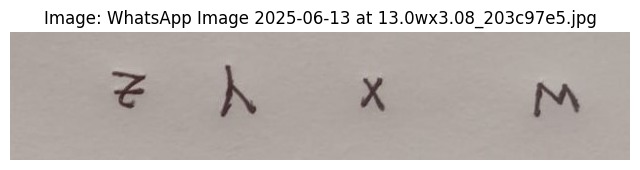

What text is written in WhatsApp Image 2025-06-13 at 13.0wx3.08_203c97e5.jpg? (enter character by character, e.g., 'Hello'): zYXW
Detected 4 characters, you entered 4 characters


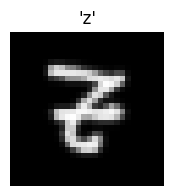

Added 'z' to fine-tuning dataset


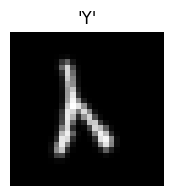

Added 'Y' to fine-tuning dataset


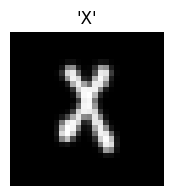

Added 'X' to fine-tuning dataset


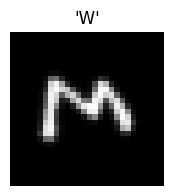

Added 'W' to fine-tuning dataset

--- Processing WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg ---


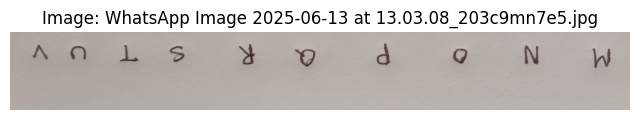

What text is written in WhatsApp Image 2025-06-13 at 13.03.08_203c9mn7e5.jpg? (enter character by character, e.g., 'Hello'): VUTSRQPONM
Detected 10 characters, you entered 10 characters


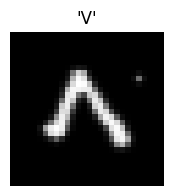

Added 'V' to fine-tuning dataset


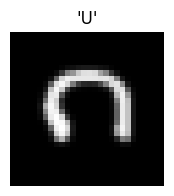

Added 'U' to fine-tuning dataset


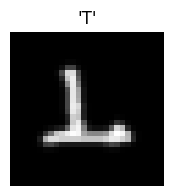

Added 'T' to fine-tuning dataset


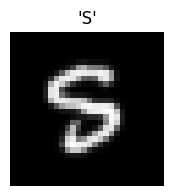

Added 'S' to fine-tuning dataset


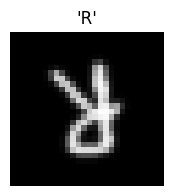

Added 'R' to fine-tuning dataset


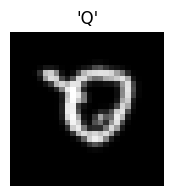

Added 'Q' to fine-tuning dataset


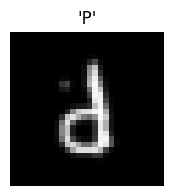

Added 'P' to fine-tuning dataset


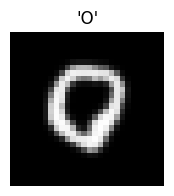

Added 'O' to fine-tuning dataset


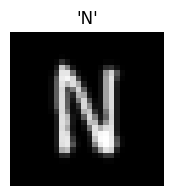

Added 'N' to fine-tuning dataset


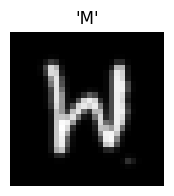

Added 'M' to fine-tuning dataset

✅ Created custom dataset with 14 samples
Characters collected: ['z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M']

=== FINE-TUNING WITH 14 CUSTOM SAMPLES ===
Augmented dataset: 84 samples
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4117 - loss: 2.1722 - val_accuracy: 1.0000 - val_loss: 0.3693
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5194 - loss: 1.6677 - val_accuracy: 1.0000 - val_loss: 0.3668
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5343 - loss: 1.5521 - val_accuracy: 1.0000 - val_loss: 0.3636
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5076 - loss: 1.6301 - val_accuracy: 1.0000 - val_loss: 0.3602
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5229 - loss: 1.5915 - val_accuracy: 1.0000 - val_loss: 0.3566
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5460 - loss: 1.3489 - val_accuracy: 1.0000 - val_loss: 0.3541
Epoch 7/1

✅ Fine-tuned model saved as 'fine_tuned_model.h5'

🎉 Fine-tuning complete!
Now test with a new image to see improved performance.
Upload a test image to see improvement? (y/n): Y
Upload test image:


Saving WhatsApp Image 2025-06-13 at 12.25.16_032e3913.jpg to WhatsApp Image 2025-06-13 at 12.25.16_032e3913.jpg
Testing with fine-tuned model...


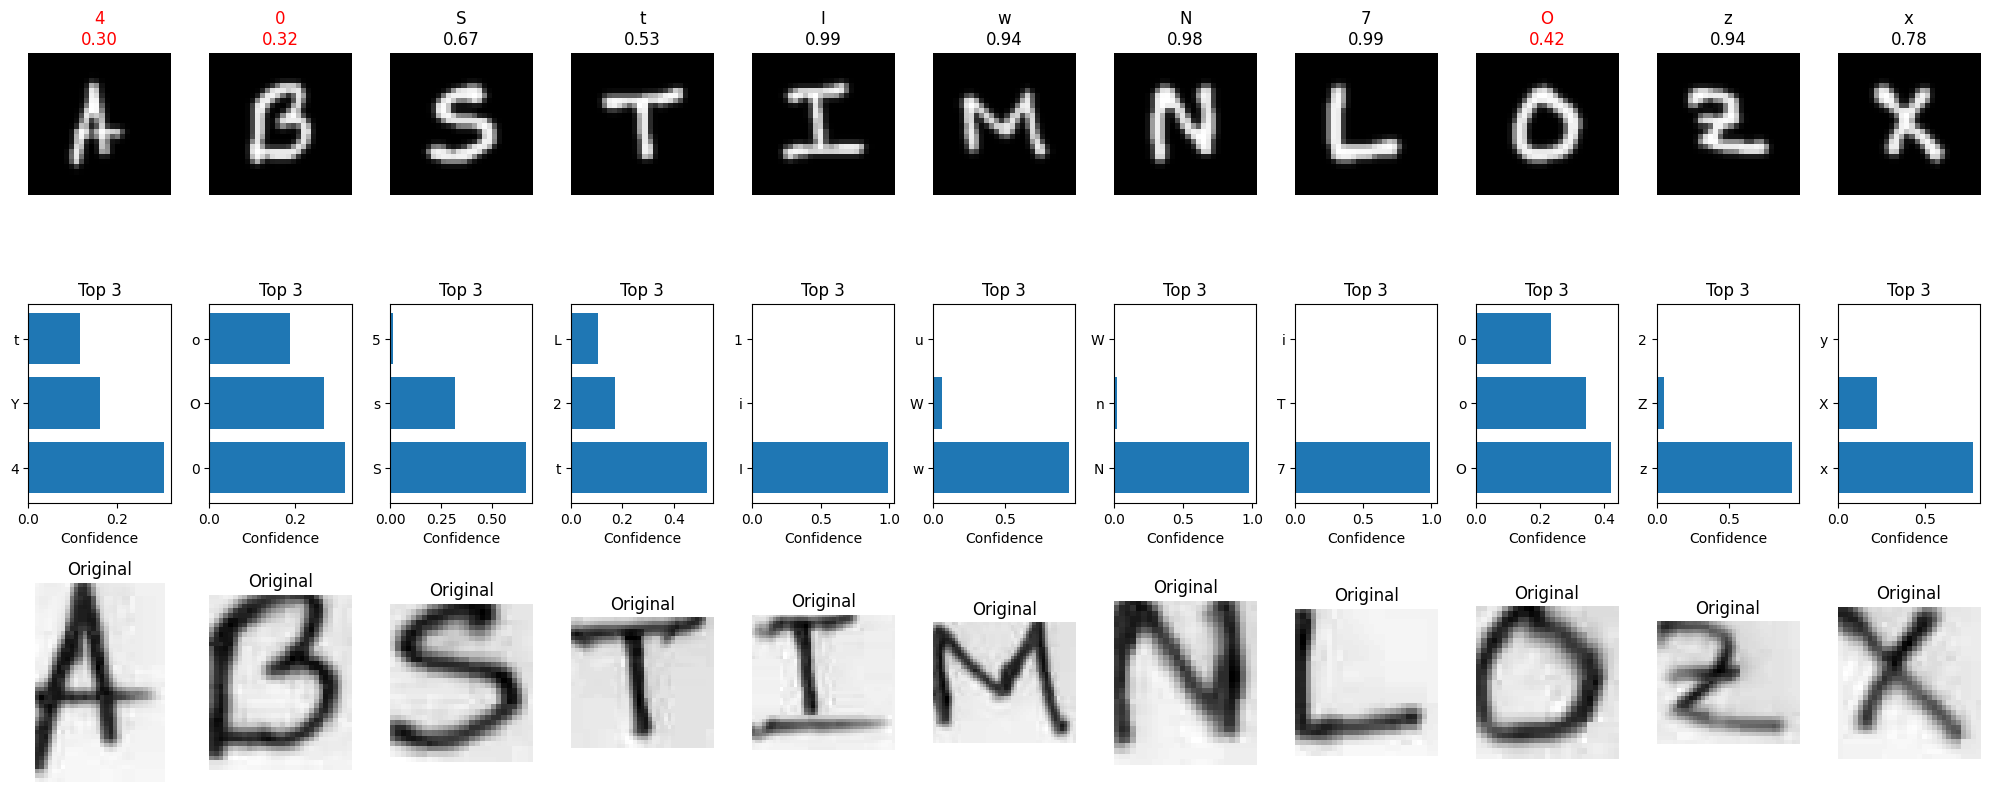

Predicted word: '40StIwN7Ozx'
Average confidence: 0.714

⚠️  LOW CONFIDENCE CHARACTERS (3):
  Position 0: '4' (confidence: 0.30)
    Alternatives: Y(0.16), t(0.12)
  Position 1: '0' (confidence: 0.32)
    Alternatives: O(0.27), o(0.19)
    💡 o/O/0 confusion detected. Check size and thickness.
  Position 8: 'O' (confidence: 0.42)
    Alternatives: o(0.34), 0(0.23)
    💡 o/O/0 confusion detected. Check size and thickness.


In [ ]:
# Cell 18: Interactive Fine-tuning Process
def interactive_fine_tuning():
    """Interactive fine-tuning process"""
    print("🎯 INTERACTIVE FINE-TUNING")
    print("This process will:")
    print("1. Let you upload images of your handwriting")
    print("2. You label what characters are written")
    print("3. System fine-tunes the model on your writing style")
    print("4. Test improved performance")

    proceed = input("\nDo you want to proceed with fine-tuning? (y/n): ")

    if proceed.lower() == 'y':
        # Collect custom data
        X_custom, y_custom = create_fine_tuning_dataset()

        if X_custom is not None:
            # Fine-tune model
            fine_tuned_model = fine_tune_model(X_custom, y_custom)

            print("\n🎉 Fine-tuning complete!")
            print("Now test with a new image to see improved performance.")

            # Test with new image
            test_fine_tuned = input("Upload a test image to see improvement? (y/n): ")
            if test_fine_tuned.lower() == 'y':
                print("Upload test image:")
                test_files = files.upload()

                if test_files:
                    test_filename = list(test_files.keys())[0]
                    print("Testing with fine-tuned model...")
                    result = predict_with_confidence_analysis(test_filename, confidence_threshold=0.5)
        else:
            print("No custom data collected. Fine-tuning skipped.")
    else:
        print("Fine-tuning skipped.")

# Run interactive fine-tuning
interactive_fine_tuning()

###UNUSED PART



In [20]:
# Cell 19: Quick Fix for Common Issues
def diagnose_and_fix_issues(image_path):
    """Diagnose common issues and suggest fixes"""
    print("🔍 DIAGNOSING IMAGE ISSUES")

    # Load and analyze image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Check image properties
    height, width = gray.shape
    print(f"Image size: {width}x{height}")

    # Check brightness
    avg_brightness = np.mean(gray)
    print(f"Average brightness: {avg_brightness:.1f}")

    # Check contrast
    contrast = np.std(gray)
    print(f"Contrast (std): {contrast:.1f}")

    # Issues and fixes
    issues = []
    fixes = []

    if avg_brightness < 100:
        issues.append("Image too dark")
        fixes.append("Increase brightness or use better lighting")

    if avg_brightness > 200:
        issues.append("Image too bright/overexposed")
        fixes.append("Reduce brightness or lighting")

    if contrast < 50:
        issues.append("Low contrast")
        fixes.append("Use darker pen or increase contrast")

    if width < 500 or height < 200:
        issues.append("Image resolution too low")
        fixes.append("Take photo closer or use higher resolution")

    if width > 3000 or height > 3000:
        issues.append("Image too large")
        fixes.append("Resize image or take photo from further away")

    # Check text orientation
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        issues.append("No text detected")
        fixes.append("Check if pen color contrasts with paper")

    # Show results
    if issues:
        print(f"\n⚠️ FOUND {len(issues)} ISSUES:")
        for i, (issue, fix) in enumerate(zip(issues, fixes)):
            print(f"{i+1}. {issue}")
            print(f"   Fix: {fix}")
    else:
        print("✅ No obvious issues detected")

    # Show processed versions
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    axes[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    axes[0,1].imshow(gray, cmap='gray')
    axes[0,1].set_title('Grayscale')
    axes[0,1].axis('off')

    axes[0,2].imshow(binary, cmap='gray')
    axes[0,2].set_title('Binary')
    axes[0,2].axis('off')

    # Apply fixes
    enhanced = cv2.equalizeHist(gray) if contrast < 50 else gray
    axes[1,0].imshow(enhanced, cmap='gray')
    axes[1,0].set_title('Enhanced')
    axes[1,0].axis('off')

    # Brightness adjusted
    bright_adj = cv2.convertScaleAbs(gray, alpha=1.2, beta=30) if avg_brightness < 100 else gray
    axes[1,1].imshow(bright_adj, cmap='gray')
    axes[1,1].set_title('Brightness Adjusted')
    axes[1,1].axis('off')

    # Final processed
    final = advanced_preprocess_image(image_path)
    axes[1,2].imshow(final, cmap='gray')
    axes[1,2].set_title('Final Processed')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 20: Complete Testing Suite
print("""
🚀 COMPLETE TESTING SUITE READY!

Available Functions:
1. Upload image → Automatic multi-method testing
2. interactive_fine_tuning() → Customize model for your handwriting
3. diagnose_and_fix_issues('image.jpg') → Debug image problems
4. analyze_confusing_pairs() → Check model performance on tricky characters

Tips for Best Results:
📸 Photo: Good lighting, straight angle, steady hand
✏️ Writing: Dark pen, white paper, clear spacing
🎯 Size: Characters at least 1cm tall
💡 Issues: Use diagnose_and_fix_issues() if recognition fails """)


🚀 COMPLETE TESTING SUITE READY!

Available Functions:
1. Upload image → Automatic multi-method testing
2. interactive_fine_tuning() → Customize model for your handwriting
3. diagnose_and_fix_issues('image.jpg') → Debug image problems
4. analyze_confusing_pairs() → Check model performance on tricky characters

Tips for Best Results:
📸 Photo: Good lighting, straight angle, steady hand
✏️ Writing: Dark pen, white paper, clear spacing
🎯 Size: Characters at least 1cm tall
💡 Issues: Use diagnose_and_fix_issues() if recognition fails 


In [ ]:
# Cell 11: Model Improvement Tips and Fine-tuning
print("""
Model Improvement Tips:
1. If accuracy is low, try:
   - Taking clearer photos with good lighting
   - Writing characters larger and more clearly
   - Using dark pen/pencil on white paper
   - Ensuring characters don't touch each other

2. For better segmentation:
   - Leave space between characters
   - Write on lined paper for better alignment
   - Use consistent character size

3. Model fine-tuning options:
   - Collect your own handwriting samples
   - Add data augmentation
   - Adjust threshold parameters
   - Use different preprocessing techniques
""")

# Function to save the model
def save_model_for_deployment():
    """Save the trained model"""
    model.save('handwriting_recognition_model.h5')

    # Save character mapping
    import pickle
    with open('char_mapping.pkl', 'wb') as f:
        pickle.dump(char_mapping, f)

    print("Model and character mapping saved!")

# Uncomment to save the model
save_model_for_deployment()


Model Improvement Tips:
1. If accuracy is low, try:
   - Taking clearer photos with good lighting
   - Writing characters larger and more clearly
   - Using dark pen/pencil on white paper
   - Ensuring characters don't touch each other

2. For better segmentation:
   - Leave space between characters
   - Write on lined paper for better alignment
   - Use consistent character size

3. Model fine-tuning options:
   - Collect your own handwriting samples
   - Add data augmentation
   - Adjust threshold parameters
   - Use different preprocessing techniques

Model and character mapping saved!


In [ ]:
# Cell 9.1: Upload and Test Your Handwriting with Enhanced Analysis
print("Upload your handwritten image:")
uploaded = files.upload()

if uploaded:
    # Get the uploaded file name
    image_name = list(uploaded.keys())[0]
    print(f"Processing image: {image_name}")

    # Display the original image
    img = Image.open(io.BytesIO(uploaded[image_name]))
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Try multiple orientations and preprocessing methods
    print("\n" + "="*50)
    print("TRYING MULTIPLE ORIENTATIONS AND METHODS")
    print("="*50)

    # Method 1: Original image with enhanced preprocessing
    print("\n--- Method 1: Enhanced Preprocessing ---")
    try:
        result1 = predict_with_confidence_analysis(image_name, confidence_threshold=0.6)
        if result1:
            word1, preds1, low_conf1 = result1
            print(f"Result 1: '{word1}'")
    except Exception as e:
        print(f"Method 1 failed: {e}")
        result1 = None

    # Method 2: Try with different rotation/flip
    print("\n--- Method 2: Flipped Vertically ---")
    try:
        # Create flipped version
        original_img = cv2.imread(image_name)
        flipped_img = cv2.flip(original_img, 0)  # Flip vertically
        flipped_name = f"flipped_{image_name}"
        cv2.imwrite(flipped_name, flipped_img)

        result2 = predict_with_confidence_analysis(flipped_name, confidence_threshold=0.6)
        if result2:
            word2, preds2, low_conf2 = result2
            print(f"Result 2 (flipped): '{word2}'")
    except Exception as e:
        print(f"Method 2 failed: {e}")
        result2 = None

    # Method 3: Try with 180-degree rotation
    print("\n--- Method 3: Rotated 180° ---")
    try:
        # Create rotated version
        # rows, cols = original_img.shape[:2]
        # rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 180, 1)
        # rotated_img = cv2.warpAffine(original_img, rotation_matrix, (cols, rows))
        rotated_img = cv2.flip(cv2.flip(original_img, 0), 1)



        rotated_name = f"rotated_{image_name}"
        cv2.imwrite(rotated_name, rotated_img)

        result3 = predict_with_confidence_analysis(rotated_name, confidence_threshold=0.6)
        if result3:
            word3, preds3, low_conf3 = result3
            print(f"Result 3 (rotated): '{word3}'")
    except Exception as e:
        print(f"Method 3 failed: {e}")
        result3 = None

    # Compare results and suggest best one
    print("\n" + "="*50)
    print("RESULTS COMPARISON")
    print("="*50)

    results = []
    if result1: results.append(("Original", result1[0], result1[2]))
    if result2: results.append(("Flipped", result2[0], result2[2]))
    if result3: results.append(("Rotated", result3[0], result3[2]))

    if results:
        # Find result with highest confidence (least low-confidence characters)
        best_result = min(results, key=lambda x: len(x[2]))
        print(f"🏆 BEST RESULT: {best_result[0]} - '{best_result[1]}'")
        print(f"   Low confidence characters: {len(best_result[2])}")

        for method, word, low_conf in results:
            print(f"{method}: '{word}' (low conf: {len(low_conf)})")
    else:
        print("❌ All methods failed. Try:")
        print("1. Better lighting")
        print("2. Clearer handwriting")
        print("3. Dark pen on white paper")
        print("4. Larger characters")

    # Run detailed analysis on original image
    print("\n--- DETAILED ANALYSIS (Original Image) ---")
    analyze_predictions(image_name)

Upload your handwritten image:


NameError: name 'files' is not defined

In [ ]:
# Cell 7: Image Preprocessing Functions
def preprocess_image(image_path):
    """Preprocess uploaded image for prediction"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not read image")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply adaptive threshold to get binary image
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    return binary

def segment_characters(binary_image):
    """Segment individual characters from the image"""
    # Find contours
    contours, _ = cv2.findContours(
        binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter and sort contours
    character_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter small contours
            x, y, w, h = cv2.boundingRect(contour)
            # Filter based on aspect ratio and size
            if 0.2 < h/w < 5 and w > 10 and h > 10:
                character_contours.append((x, y, w, h))

    # Sort by x-coordinate (left to right)
    character_contours.sort(key=lambda x: x[0])

    return character_contours

def extract_and_resize_character(image, bbox):
    """Extract character from bounding box and resize to 28x28"""
    x, y, w, h = bbox

    # Extract character region
    char_img = image[y:y+h, x:x+w]

    # Add padding to make it square
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2

    padded = cv2.copyMakeBorder(
        char_img, pad_h, pad_h, pad_w, pad_w,
        cv2.BORDER_CONSTANT, value=0
    )

    # Resize to 28x28
    resized = cv2.resize(padded, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize
    normalized = resized.astype('float32') / 255.0

    return normalized

In [29]:
# # Cell 8: Character Prediction Function
# def predict_characters(image_path):
#     """Predict characters from handwritten text image"""
#     try:
#         # Preprocess image
#         binary_img = advanced_preprocess_image(image_path)

#         # Segment characters
#         char_bboxes = segment_characters(binary_img)

#         if not char_bboxes:
#             print("No characters detected in the image")
#             return ""

#         # Extract and predict each character
#         predictions = []
#         characters = []

#         plt.figure(figsize=(15, 5))

#         for i, bbox in enumerate(char_bboxes):
#             # Extract character
#             char_img = improved_character_extraction(binary_img, bbox)
#             characters.append(char_img)

#             # Predict
#             char_input = char_img.reshape(1, 28, 28, 1)
#             prediction = model.predict(char_input, verbose=0)
#             predicted_class = np.argmax(prediction)
#             confidence = np.max(prediction)

#             predicted_char = char_mapping[predicted_class]
#             predictions.append((predicted_char, confidence))

#             # Visualize
#             plt.subplot(2, len(char_bboxes), i + 1)
#             plt.imshow(char_img, cmap='gray')
#             plt.title(f'{predicted_char}\n({confidence:.2f})')
#             plt.axis('off')

#             # Show original region
#             plt.subplot(2, len(char_bboxes), len(char_bboxes) + i + 1)
#             x, y, w, h = bbox
#             original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#             char_region = original_img[y:y+h, x:x+w]
#             plt.imshow(char_region, cmap='gray')
#             plt.title('Original')
#             plt.axis('off')

#         plt.tight_layout()
#         plt.show()

#         # Combine predictions
#         predicted_word = ''.join([pred[0] for pred in predictions])
#         avg_confidence = np.mean([pred[1] for pred in predictions])

#         print(f"Predicted word: '{predicted_word}'")
#         print(f"Average confidence: {avg_confidence:.3f}")

#         return predicted_word, predictions

#     except Exception as e:
#         print(f"Error processing image: {str(e)}")
#         return ""
# Modified predict_characters function

In [ ]:
# # Cell 15.1: Confidence-Based Prediction with Context
# def predict_with_confidence_analysis(image_path, confidence_threshold=0.7):
#     """Enhanced prediction with confidence analysis and suggestions"""
#     try:
#         # Use advanced preprocessing
#         binary_img = advanced_preprocess_image(image_path)

#         # Segment characters
#         char_bboxes = segment_characters_with_spaces(binary_img)

#         if not char_bboxes:
#             print("No characters detected in the image")
#             return ""

#         predictions = []
#         low_confidence_chars = []

#         plt.figure(figsize=(20, 8))

#         for i, bbox in enumerate(char_bboxes):
#             # Extract character with improved method
#             char_img = improved_character_extraction(binary_img, bbox)

#             # Predict
#             char_input = char_img.reshape(1, 28, 28, 1)
#             prediction = model.predict(char_input, verbose=0)

#             # Get top 3 predictions
#             top_3_indices = np.argsort(prediction[0])[-3:][::-1]
#             top_3_probs = prediction[0][top_3_indices]
#             top_3_chars = [char_mapping[idx] for idx in top_3_indices]

#             predicted_char = top_3_chars[0]
#             confidence = top_3_probs[0]

#             predictions.append((predicted_char, confidence, top_3_chars, top_3_probs))

#             # Check for low confidence
#             if confidence < confidence_threshold:
#                 low_confidence_chars.append({
#                     'position': i,
#                     'char': predicted_char,
#                     'confidence': confidence,
#                     'alternatives': list(zip(top_3_chars, top_3_probs))
#                 })

#             # Visualize with top predictions
#             plt.subplot(3, len(char_bboxes), i + 1)
#             plt.imshow(char_img, cmap='gray')
#             plt.title(f'{predicted_char}\n{confidence:.2f}')
#             if confidence < confidence_threshold:
#                 plt.title(f'{predicted_char}\n{confidence:.2f}', color='red')
#             plt.axis('off')

#             # Show top 3 predictions
#             plt.subplot(3, len(char_bboxes), len(char_bboxes) + i + 1)
#             y_pos = np.arange(3)
#             plt.barh(y_pos, top_3_probs)
#             plt.yticks(y_pos, top_3_chars)
#             plt.xlabel('Confidence')
#             plt.title('Top 3')

#             # Show original region
#             plt.subplot(3, len(char_bboxes), 2*len(char_bboxes) + i + 1)
#             x, y, w, h = bbox
#             original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#             char_region = original_img[y:y+h, x:x+w]
#             plt.imshow(char_region, cmap='gray')
#             plt.title('Original')
#             plt.axis('off')

#         plt.tight_layout()
#         plt.show()

#         # Print results
#         predicted_word = ''.join([pred[0] for pred in predictions])
#         avg_confidence = np.mean([pred[1] for pred in predictions])

#         print(f"Predicted word: '{predicted_word}'")
#         print(f"Average confidence: {avg_confidence:.3f}")

#         # Show low confidence warnings
#         if low_confidence_chars:
#             print(f"\n⚠️  LOW CONFIDENCE CHARACTERS ({len(low_confidence_chars)}):")
#             for char_info in low_confidence_chars:
#                 pos = char_info['position']
#                 char = char_info['char']
#                 conf = char_info['confidence']
#                 alts = char_info['alternatives']

#                 print(f"  Position {pos}: '{char}' (confidence: {conf:.2f})")
#                 print(f"    Alternatives: {', '.join([f'{c}({p:.2f})' for c, p in alts[1:]])}")

#                 # Specific suggestions for common confusions
#                 if char in ['M', 'm', 'w', 'W']:
#                     print(f"    💡 M/m/w/W confusion detected. Check letter shape and size.")
#                 elif char in ['s', 'S', '5']:
#                     print(f"    💡 s/S/5 confusion detected. Check curves and angles.")
#                 elif char in ['o', 'O', '0']:
#                     print(f"    💡 o/O/0 confusion detected. Check size and thickness.")
#                 elif char in ['I', 'l', '1', 'T']:
#                     print(f"    💡 I/l/1/T confusion detected. Check serifs and horizontal lines.")

#         return predicted_word, predictions, low_confidence_chars

#     except Exception as e:
#         print(f"Error processing image: {str(e)}")
#         return ""
